<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles.


## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.cluster import KMeans
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
OSEBuildingID                                               0   
DataYear                                                    0   
BuildingType                                                0   
PrimaryPropertyType                                         0   
PropertyName                                                0   
Address                                                     0   
City                                                        0   
State                                                       0   
ZipCode                                                    16   
TaxParcelIdentificationNumber                               0   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
YearBuilt                                                   0   
NumberofBuildings                                           8   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
PropertyGFABuilding(s)                                      0   
ListOfAllPropertyUseTypes                                   9   
LargestPropertyUseType                                     20   
LargestPropertyUseTypeGFA                                  20   
SecondLargestPropertyUseType                             1697   
SecondLargestPropertyUseTypeGFA                          1697   
ThirdLargestPropertyUseType                              2780   
ThirdLargestPropertyUseTypeGFA                           2780   
YearsENERGYSTARCertified                                 3257   
ENERGYSTARScore                                           843   
SiteEUI(kBtu/sf)                                            7   
SiteEUIWN(kBtu/sf)                                          6   
SourceEUI(kBtu/sf)                                          9   
SourceEUIWN(kBtu/sf)                                        9   
SiteEnergyUse(kBtu)                                         5   
SiteEnergyUseWN(kBtu)                                       6   
SteamUse(kBtu)                                              9   
Electricity(kWh)                                            9   
Electricity(kBtu)                                           9   
NaturalGas(therms)                                          9   
NaturalGas(kBtu)                                            9   
DefaultData                                                 0   
Comments                                                 3376   
ComplianceStatus                                            0   
Outlier                                                  3344   
TotalGHGEmissions                                           9   
GHGEmissionsIntensity                                       9   

                                 Pourcentage de valeurs manquantes  
OSEBuildingID                                                 0.00  
DataYear                                                      0.00  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
PropertyName                                                  0.00  
Address                                                       0.00  
City                                                          0.00  
State                                                         0.00  
ZipCode                                                       0.47  
TaxParcelIdentificationNumber                                 0.00  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude  

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

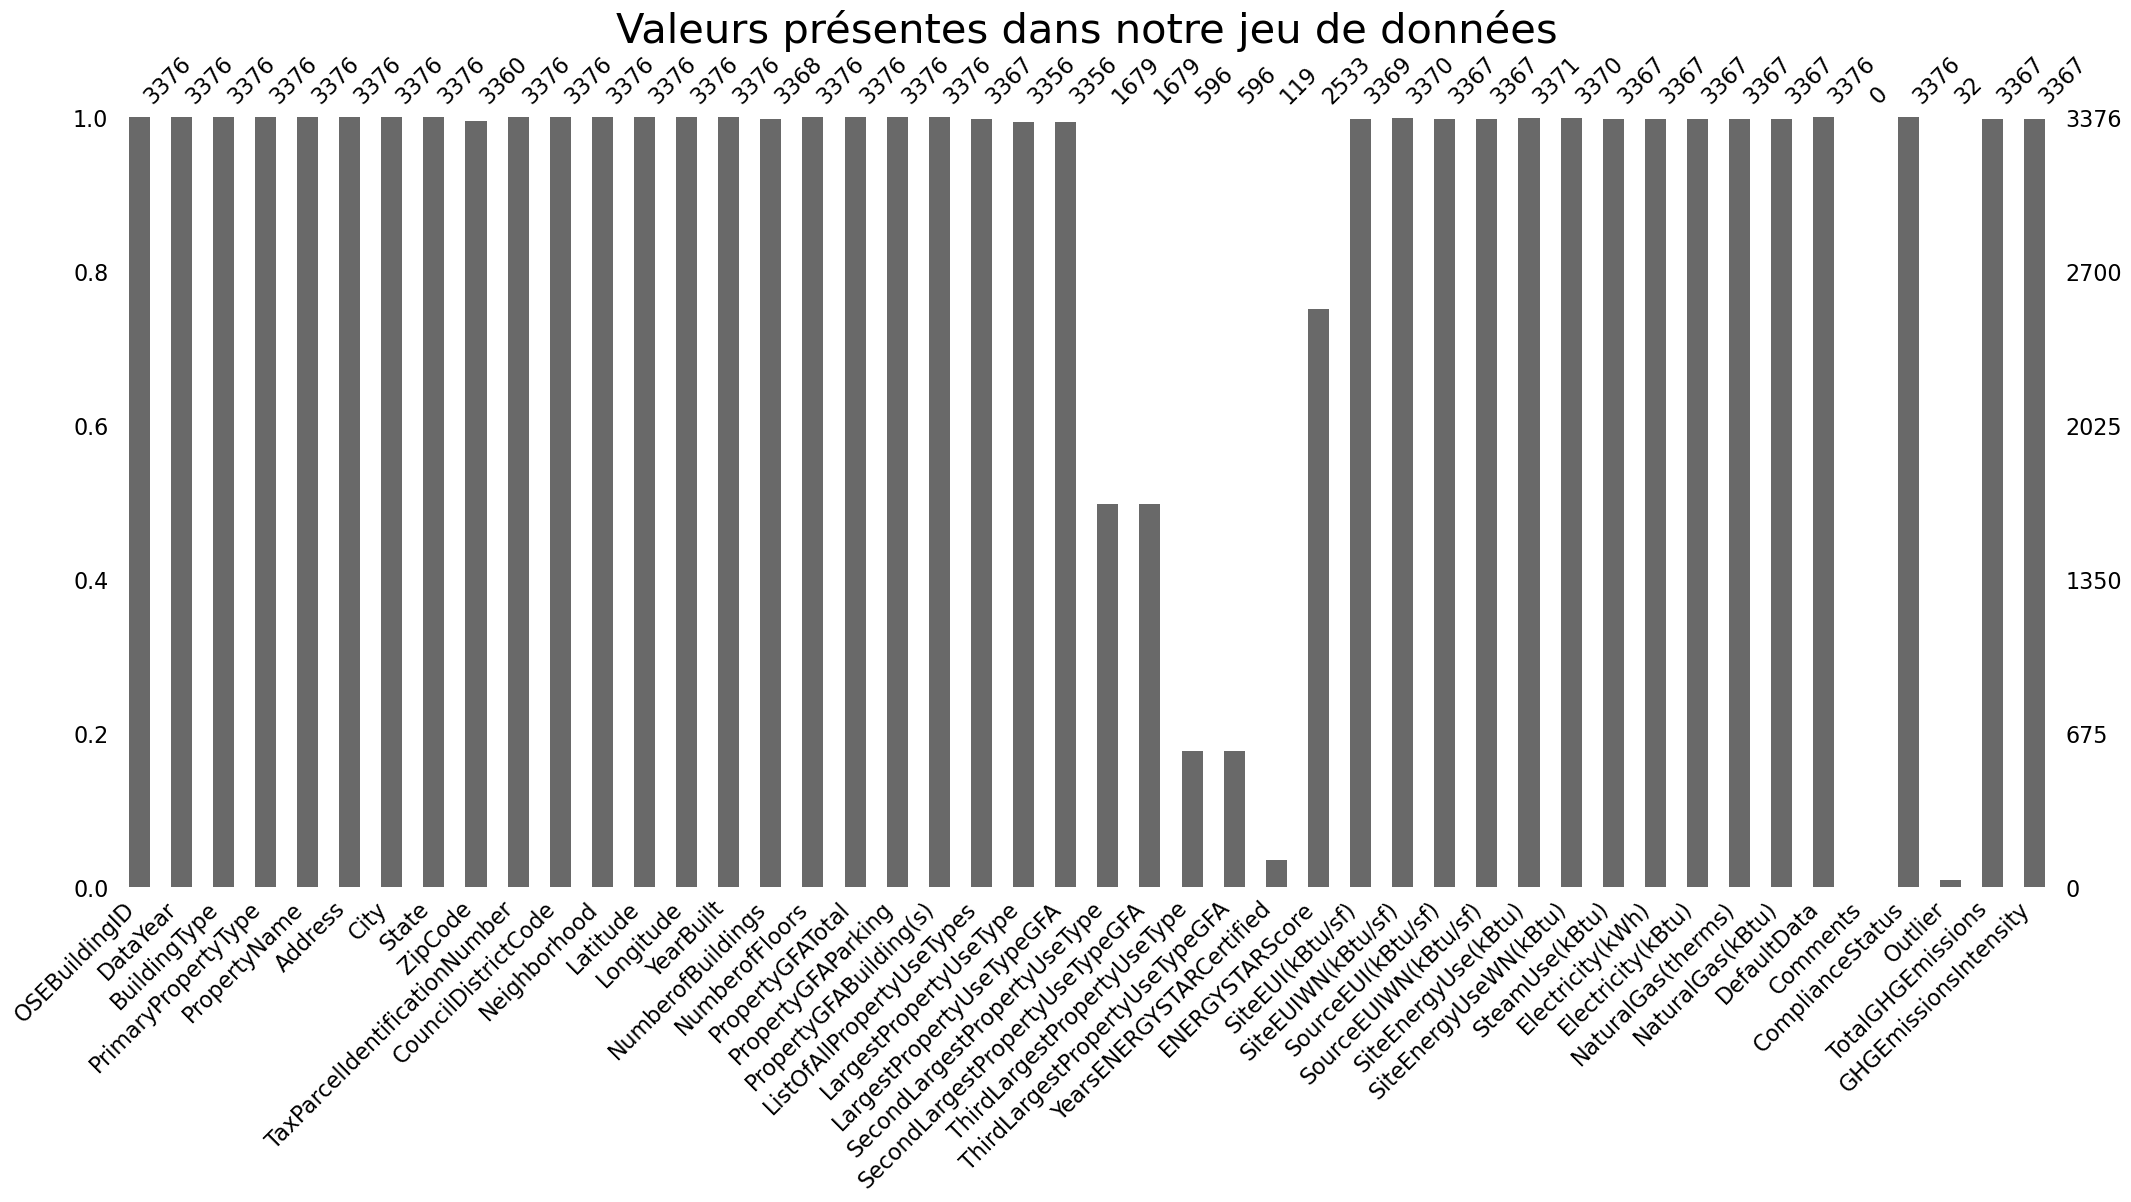

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

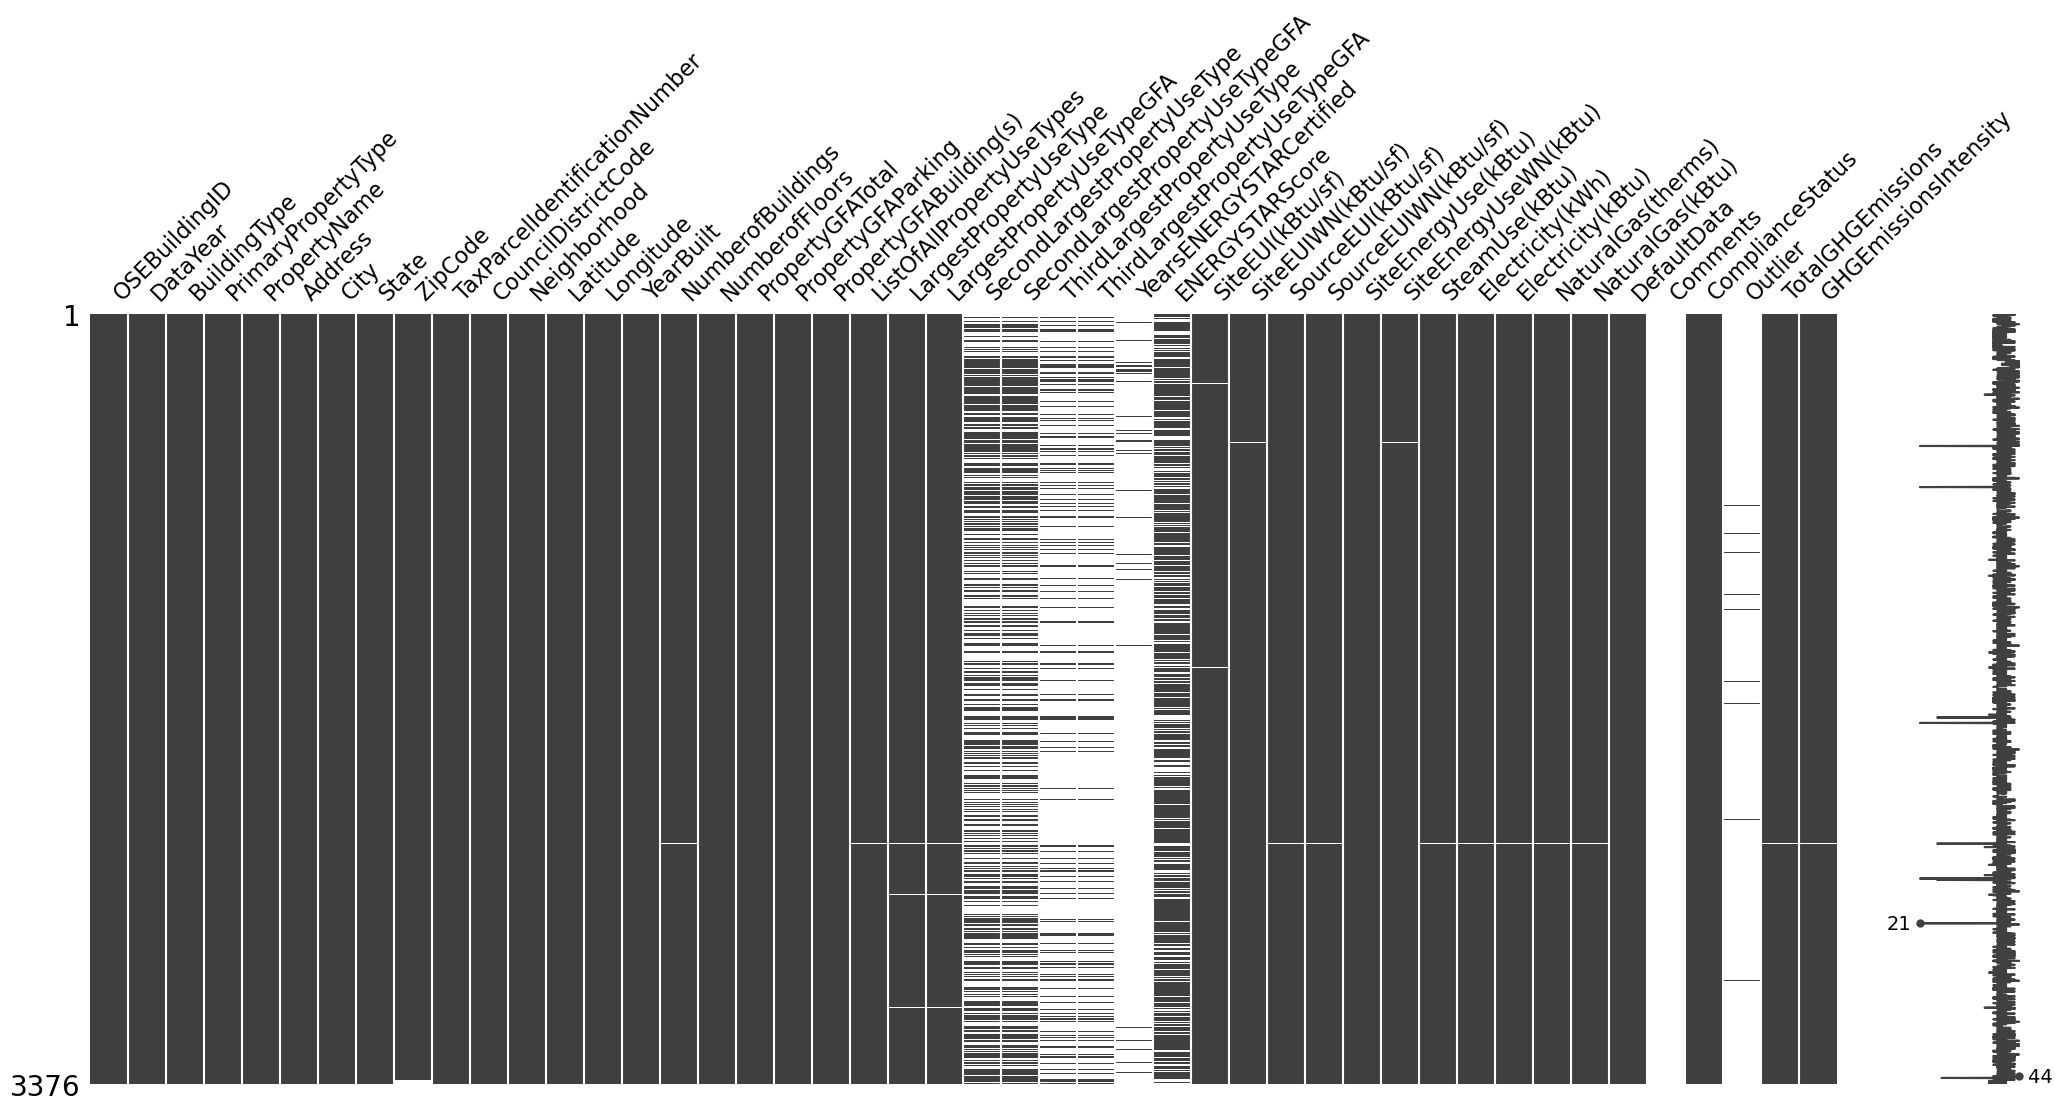

In [15]:
msno.matrix(data)

<Axes: >

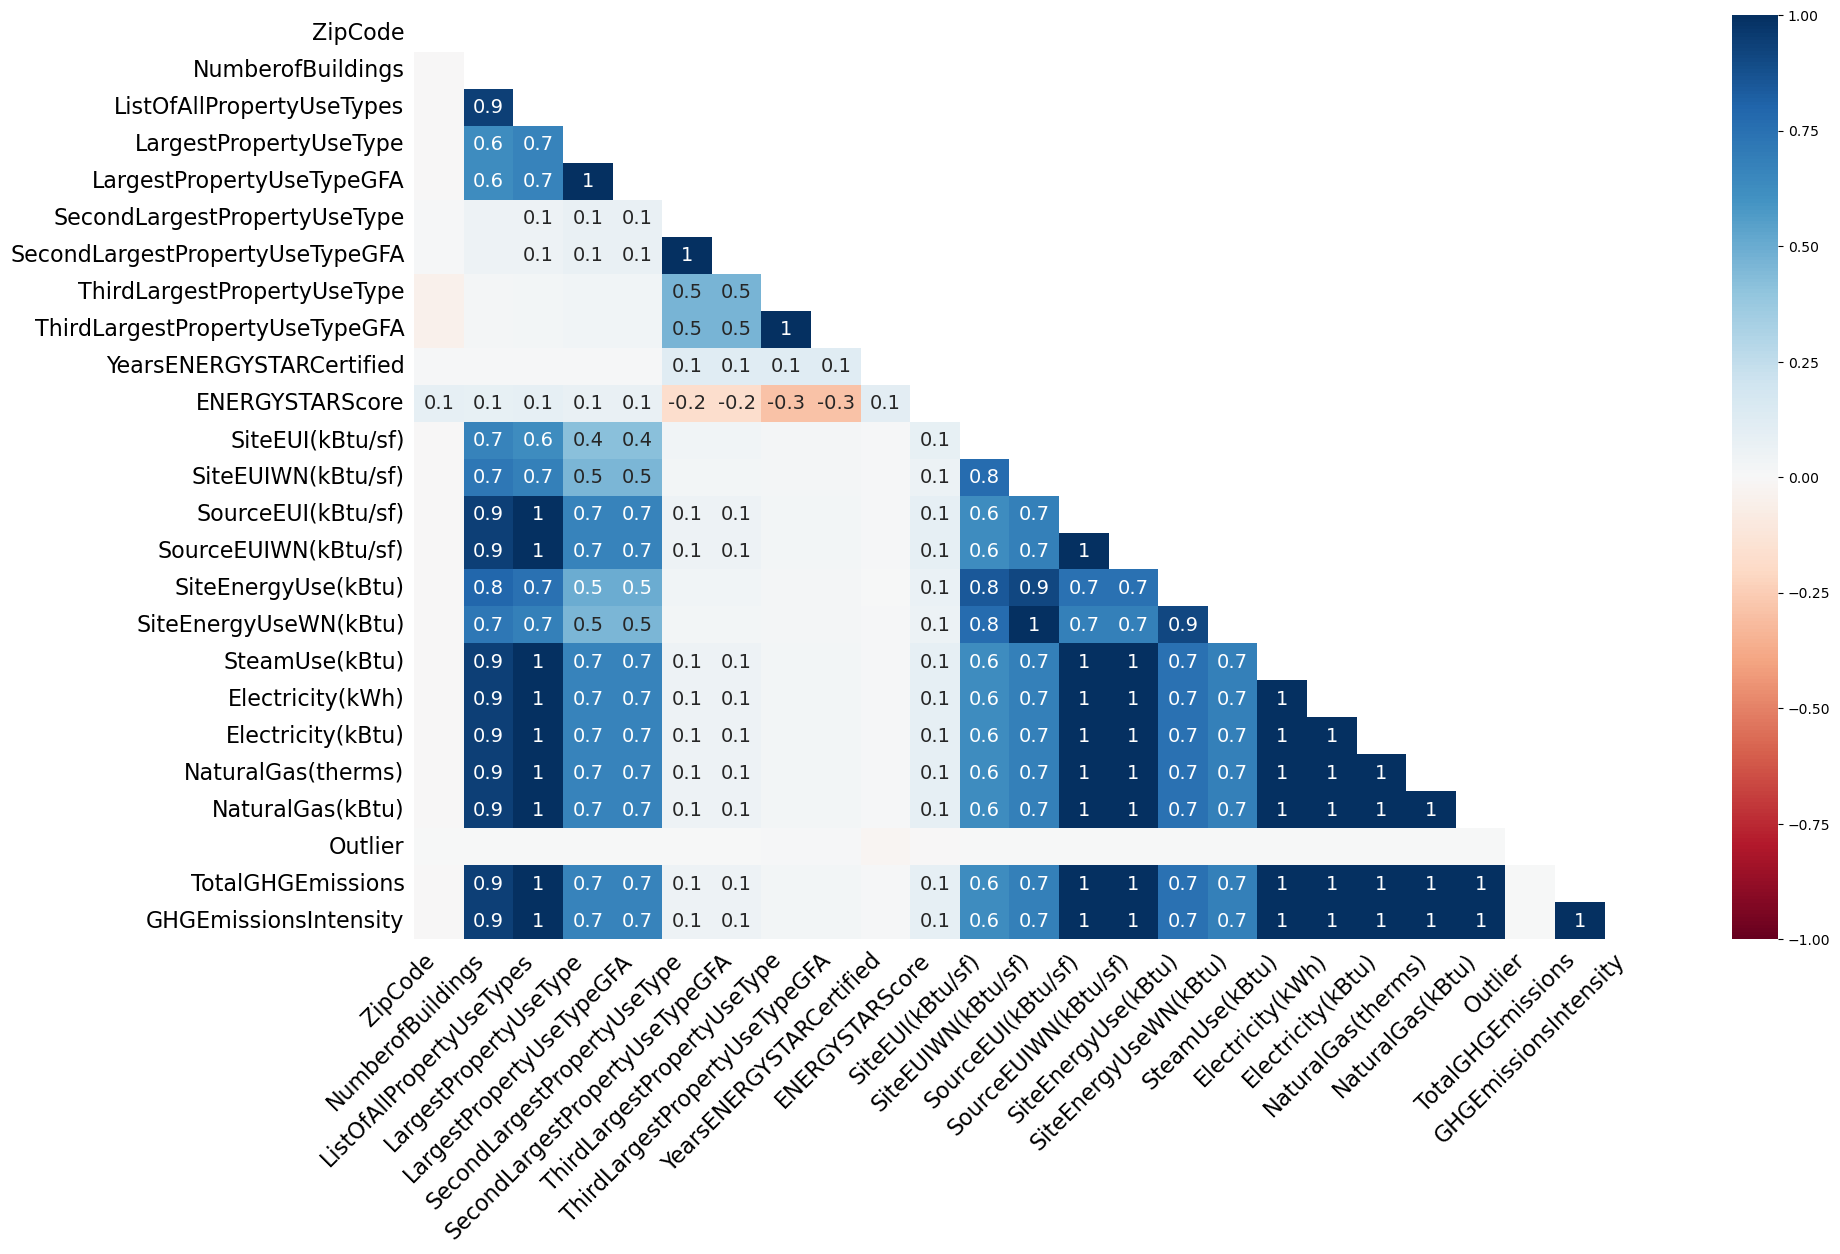

In [16]:
msno.heatmap(data)

## Compréhension des Variables

Différents groupes de variables :<br>

- Identification :<br>
OSEBuildingID
PropertyName
TaxParcelIdentificationNumber<br>
=> on les garde le temps de vérifier les doublons

- Localisation :<br>
Address, ZipCode, City, State
CouncilDistrictCode
Neighborhood
Latitude, longitude
=> on garde adresse et zipcode pour vérifier les outliers manuellement<br>
=> City et State ont des valeurs uniques => supprimés<br>
=> Latitude, longitude pour vérifier les outliers<br>
=> Zipcode, CouncilDistrictCode Neighborhood => On choisi Neighborhood car pas de valeurs manquantes et plus de catégories<br>

- Type de batiment/utilisation :<br>
BuildingType
ListOfAllPropertyUseTypes 	
PrimaryPropertyType
LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType<br>
=> on garde tout pour le moment même si primarypropertytype et largestpropertytype semblent similaires<br>

- Surface :<br>
PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s)<br>
LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA<br>
=> on garde tout <br>

- Energie :<br>
SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf) 	
SiteEnergyUse(kBtu), **SiteEnergyUseWN(kBtu)**
SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms),  NaturalGas(kBtu)<br>
=> on conserve tout pour les vérifications des valeurs mais on ne conservera pas les fuites de données par la suite<br>

- GES :<br>
**TotalGHGEmissions**, GHGEmissionsIntensity<br>
=> On garde tout pour le moment

- Bâtiment :<br>
YearBuilt
NumberofBuildings
NumberofFloors<br>
=> on garde tout <br>

- Energystarscore :<br>
YearsENERGYSTARCertified
**ENERGYSTARScore**<br>
=> on garde seulement l'EnergyStarScore, il y a trop de valeurs manquantes pour l'année<br>

- Autre :<br>
DefaultData
Comments 
ComplianceStatus
Outlier<br>
=> Comments à supprimer car vide, les autres à regarder en détail

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 
                'YearsENERGYSTARCertified', 'Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
DefaultData                           bool
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
ListOfAllPropertyUseTypes           object
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFA

## Recherche des doublons

In [19]:
nb_doublons_code = data.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [20]:
nb_doublons_add = data.duplicated(subset=['Address', 'PropertyName']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 0


## Vérification des données

In [21]:
df = data.copy()

In [22]:
def find_outliers(df, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df[outlier_var].quantile(0.25)
    q3 = df[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filtrer les outliers
    outliers = df[(df[outlier_var] < lower_bound) | (df[outlier_var] > upper_bound)]
    return outliers

In [23]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé

### BuildingType

In [24]:
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [25]:
df = df[~df['BuildingType'].str.contains("Multifamily", na=False)].copy()

In [26]:
df.shape

(1668, 46)

### ComplianceStatus

In [27]:
print(df['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       1548
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.<br>
=> Suppression, On conserve les Compliant et Missing Data


In [28]:
df = df[~df['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df = df[~df['ComplianceStatus'].str.contains("Error", na=False)].copy()
df = df.drop(columns=['ComplianceStatus'])

### DefaultData

In [29]:
print(df['DefaultData'].value_counts())

DefaultData
False    1562
Name: count, dtype: int64


Les valeurs par défaut peuvent avoir biaisé nos données, nous choisissons de supprimer ces batiments.

In [30]:
df = df[df['DefaultData'] != True]
df = df.drop(columns=['DefaultData'])

### Outlier

In [31]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


On conserve pour le moment pour vérifier s'il y a un impact sur nos modèles.

### Latitude et Longitude

Seattle :<br>
    - Longitude minimale : aux alentours de -122.436 (ouest)<br>
    - Longitude maximale : aux alentours de -122.255 (est)

In [32]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df[(df['Longitude'] < longitude_min) | (df['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'Latitude', 'Longitude']]

Empty DataFrame
Columns: [Address, Latitude, Longitude]
Index: []

### Neighborhood

In [33]:
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'Central' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'CENTRAL'
 'SOUTHWEST' 'DELRIDGE' 'SOUTHEAST' 'NORTH' 'North' 'Delridge' 'Ballard'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [34]:
# Corrections
df['Neighborhood'] = df['Neighborhood'].str.upper()
df['Neighborhood'] = df['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'CENTRAL' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'SOUTHWEST'
 'DELRIDGE' 'SOUTHEAST' 'NORTH']


### NumberofBuildings

In [35]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

NumberofBuildings
NumberofBuildings                   
111.0                              1
27.0                               1
23.0                               1
14.0                               2
11.0                               1
10.0                               1
9.0                                1
8.0                                2
7.0                                1
6.0                                4
5.0                                7
4.0                                4
3.0                               12
2.0                               14
1.0                             1458
0.0                               52

Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [36]:
df.loc[df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1.

Les adresses avec plus de 10 bâtiments sont à vérifier.

In [37]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df[df['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'ZipCode', 'NumberofBuildings', 'PrimaryPropertyType']]

Address  ZipCode  NumberofBuildings  \
105             6000 16th Ave SW  98106.0               27.0   
128           9600 COLLEGE WAY N  98103.0               11.0   
162               1420 S Trenton  98108.0               14.0   
1862  1900 West Nickerson Street  98119.0               23.0   
2325             3307 3rd Ave. W  98119.0               14.0   
3274   NE 45th St & Brooklyn Ave  98105.0              111.0   

     PrimaryPropertyType  
105           University  
128           University  
162         Large Office  
1862               Other  
2325          University  
3274          University

Nombre de batiments pas abérrants après vérifications sur google maps.

### NumberofFloors 

In [38]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

NumberofFloors
NumberofFloors                
99                           1
76                           1
63                           1
56                           1
55                           1
49                           1
47                           1
46                           1
42                           5
41                           2
39                           1
37                           1
36                           2
34                           2
33                           3
30                           1
29                           3
28                           1
27                           1
25                           3
24                           3
23                           3
22                           3
21                           3
20                           3
19                           5
18                           3
17                           4
16                           3
15                           6
14                           9
13                           7
12                           9
11                          18
10                          18
9                            8
8                           22
7                           33
6                           81
5                          102
4                          140
3                          247
2                          354
1                          429
0                           16

In [39]:
# Colonnes à afficher
cols_to_display = ['Address', 'NumberofFloors', 'PrimaryPropertyType']
print(df[cols_to_display].loc[df['NumberofFloors'] >60])

                       Address  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue              63        Large Office
559             701 5th Avenue              76        Large Office
1359  5801 Beacon Avenue South              99    Worship Facility


A corriger : <br>
    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [40]:
df.loc[df['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [41]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'NumberofFloors', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

Address  NumberofFloors  \
2                       1900 5th Avenue              41   
13                         1113 6th Ave              33   
49                      1400 6th Avenue              34   
15                   1000 Fourth Avenue              11   
20                          516 3RD AVE              10   
21                          500 5TH AVE              19   
119                       1900 9th Ave.              11   
187                        1122 3rd Ave              15   
298                          120 Lenora              12   
558                        2001 6th Ave              33   
246                      1220 HOWELL ST              11   
410              1200 12th Avenue South              14   
1773                 1500-1506 4th Ave.              11   
2314                      737 Olive Way              39   
2530  2201 9th Ave. / 820 Blanchard St.              19   
24                      1000 Lenora St.               7   
3095                     625 5th Ave. S              11   
475                    2203 1st Ave. S.               7   
233                    700 Fifth Avenue              63   
271                        1201 3rd ave              55   
292                       601 Union St.              56   
559                      701 5th Avenue              76   
496                    901 Boren Avenue              19   
561                       509 Olive Way              18   
205                     500 Pine Street              10   
302                     300 PINE STREET               8   
529                  619 Western Avenue               6   
186                     1118 5th Avenue               9   
952                   910 Marion Street              15   
156                      3613 4th Ave S               2   
412             7272 W. Marginal Way S.               2   
462                    270 S HANFORD ST               2   
467                      1000 1st Ave S               6   
468                      1014 1st Ave S               4   
537                      2700 4th Ave S               2   
1182             5615 W Marginal Way SW               2   
1582       1200-1210 West Nickerson st.               2   
2912                  1529 Fourth Ave W               3   
356              13000 Lake City Way NE               2   
638                1401 Broadway Avenue               3   
990              4545 Fauntleroy Way SW               2   
3116                  509-23 BROADWAY E               2   
3118                  500 Mercer Street               4   
3160                      516 1st Ave W               4   
3268                   5700 24th Ave NW               8   
3105                    1411 1st Avenue              13   

              PrimaryPropertyType  
2                           Hotel  
13                          Hotel  
49                          Hotel  
15                          Other  
20                          Other  
21                          Other  
119                         Other  
187                         Other  
298                         Other  
558                         Other  
246            Mixed Use Property  
410            Mixed Use Property  
1773           Mixed Use Property  
2314           Mixed Use Property  
2530           Mixed Use Property  
24                     University  
3095  Small- and Mid-Sized Office  
475                     Warehouse  
233                  Large Office  
271                  Large Office  
292                  Large Office  
559                  Large Office  
496                Medical Office  
561                Medical Office  
205                  Retail Store  
302                  Retail Store  
529                  Retail Store  
186                Residence Hall  
952                Residence Hall  
156           Distribution Center  
412           Distribution Center  
462           Distribution Center  
467           Distribution Center  
468           Distribution Center 

Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [42]:
df.loc[df['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [43]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df[df['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 1)
    else:
        return row['NumberofFloors']


In [44]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df['NumberofFloors'] = df.apply(replace_zero_with_mean, axis=1)

### YearBuilt

In [45]:
print("Valeurs uniques pour YearBuilt dans data:", df['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1955 1978 1989 1906 1994 1992 1961 1990 1900 1954
 1911 1973 1920 1910 1982 1908 1959 2000 1997 1962 1970 2008 1948 1965
 1929 2010 1938 1986 2002 1923 2003 1941 2006 1915 1950 1958 2009 2011
 1971 2007 1951 1964 1953 1937 1966 1963 1957 1968 1924 2005 1931 1972
 1952 1914 1913 1995 1981 1925 1976 1909 1988 1979 1947 1984 1956 1912
 1977 1960 1945 1974 1975 1946 1967 1987 1949 1940 1932 1993 1918 1905
 1902 1921 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1935 2014
 2015]


On remplace l'année de construction par l'âge du bâtiment au moment des relevés.

In [46]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
df['BuildingAge'] = 2016 - df['YearBuilt']

# Supprimer la colonne 'YearBuilt'
df.drop(columns=['YearBuilt'], inplace=True)

### Electricity

In [47]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.15

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)

In [48]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [49]:
outliers[['Electricity(kBtu)','Electricity(kWh)']]

Electricity(kBtu)  Electricity(kWh)
1670                3.0           1.00000
3206          -115417.0      -33826.80078

In [50]:
# Suppression des outliers du DataFrame
df = df[df['is_outlier'] == False]

# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [51]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'Electricity(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['Electricity(kBtu)', 'SiteEUI(kBtu/sf)', 'PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA']])
else:
    print("Aucun outlier trouvé.")

Electricity(kBtu)  SiteEUI(kBtu/sf)  PropertyGFATotal  \
2            49526664.0         96.000000            956110   
11           18083049.0         80.000000            333176   
13           13904183.0         75.500000            315952   
17           21225277.0         96.300003            416281   
43           12204406.0         46.400002            332210   
49           45545529.0         80.900002            994212   
166          39364114.0        117.900002            934292   
196          13763542.0         96.199997            254273   
262          24078107.0        104.199997            542305   
272          14578058.0        108.800003            305548   
280          19800542.0        113.800003            332067   
15           17851297.0         50.799999            412000   
20           24357833.0         83.699997            540360   
21           18257661.0        124.199997            385274   
69           14419146.0         64.300003            389000   
75           13512686.0         70.000000            262048   
119          30651644.0        261.299988            299070   
155          49439914.0         37.700001           1585960   
158          40622381.0         50.099998           1172127   
187          62197171.0        306.399994            230880   
195          13788853.0        110.599998            215476   
240          30038487.0        834.400024             36000   
298          14436981.0         98.400002            193500   
303          17663475.0         93.199997            206950   
329          46528618.0        389.100006            158738   
340          64627449.0        245.100006            535947   
442          13249663.0        180.699997            169785   
545          14100771.0        214.399994            143439   
558         274532495.0        639.700012            429405   
564          46510954.0         62.299999            947987   
587          12766128.0        146.000000             99122   
625          14573159.0        136.300003            141718   
632          18175883.0         61.200001            338063   
1276         14798552.0        113.400002            155795   
1862         26894616.0        130.699997            260241   
1993         15419770.0         91.000000            230971   
3171         23173477.0        593.599976             53575   
3182         23795911.0        159.199997            267470   
3203         41680634.0        694.700012             90679   
35          150476283.0        221.699997            494835   
65           10145313.0        204.500000             99780   
164          10139555.0         95.300003            110785   
246           9671822.0         48.400002            381381   
289          10344729.0        122.800003            137400   
301          16877013.0         77.300003            258497   
308          53506520.0        283.700012            378443   
309          74917352.0        707.299988            213834   
341          20355803.0        270.399994            159700   
346          29992691.0        171.199997            436497   
373          34936812.0        209.300003            154660   
410          18843504.0         69.400002            304052   
429          29154854.0        280.399994            251827   
441          12047762.0        232.300003            175918   
474          63822136.0        366.399994            286000   
488          29432803.0         76.300003            516407   
549          17407502.0        139.899994            287224   
2314         20663978.0         43.000000           1074552   
2530         23343425.0         54.599998           1206670   
3356         23636804.0        144.500000            345290   
1494         61672821.0         66.699997           2200000   
3274        657074389.0         93.800003           9320156   
93            3926011.0         47.900002            245587   
116           4789948.0         35.00

Pas abérrant pour un Data Center.

### NaturalGas

In [52]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [53]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [54]:
# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [55]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'NaturalGas(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)','PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA']])
else:
    print("Aucun outlier trouvé.")

NaturalGas(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  \
17          12331475.0         21225277.0    0.000000e+00   
49          23324992.0         45545529.0    1.159869e+07   
166         25683162.0         39364114.0    0.000000e+00   
194         19131155.0          6322533.0    0.000000e+00   
196         12895700.0         13763542.0    0.000000e+00   
20          20626631.0         24357833.0    0.000000e+00   
21          29602150.0         18257661.0    0.000000e+00   
119         34685331.0         30651644.0    0.000000e+00   
155         10317518.0         49439914.0    0.000000e+00   
158         18138920.0         40622381.0    0.000000e+00   
195         10228916.0         13788853.0    0.000000e+00   
329          9571816.0         46528618.0    5.650344e+06   
340         66746425.0         64627449.0    0.000000e+00   
379          6377238.0         10708106.0    0.000000e+00   
442          5905752.0         13249663.0    0.000000e+00   
502          8369038.0         12356956.0    0.000000e+00   
545         11530741.0         14100771.0    0.000000e+00   
619          7116213.0          4031128.0    0.000000e+00   
687          7361709.0          3598398.0    0.000000e+00   
1125         6000871.0          4233850.0    0.000000e+00   
1279         8683709.0          9002735.0    0.000000e+00   
1593         5490664.0          1749609.0    0.000000e+00   
1862         7118362.0         26894616.0    0.000000e+00   
1993         5602515.0         15419770.0    0.000000e+00   
2522        15239341.0          7528486.0    0.000000e+00   
3168         9110455.0          9359884.0    0.000000e+00   
3171         8630089.0         23173477.0    0.000000e+00   
3233        13628209.0         12331431.0    0.000000e+00   
3254         8088416.0          4007401.0    0.000000e+00   
35         297909000.0        150476283.0    0.000000e+00   
47          10393737.0          4632459.0    0.000000e+00   
198          6606397.0          3787933.0    0.000000e+00   
289          4595774.0         10344729.0    0.000000e+00   
341         11015812.0         20355803.0    0.000000e+00   
346         15259662.0         29992691.0    0.000000e+00   
429         17947572.0         29154854.0    0.000000e+00   
441         10482405.0         12047762.0    0.000000e+00   
488          9970512.0         29432803.0    0.000000e+00   
1773         4943709.0          4602455.0    0.000000e+00   
2314         5752789.0         20663978.0    0.000000e+00   
2380         8838336.0          6642344.0    0.000000e+00   
2530         4341053.0         23343425.0    0.000000e+00   
3136         4584911.0          3890327.0    0.000000e+00   
3356        15727308.0         23636804.0    0.000000e+00   
105         12987166.0         25314575.0    0.000000e+00   
1494        52975694.0         61672821.0    0.000000e+00   
2324        10274835.0          6103316.0    0.000000e+00   
2325        67990538.0         22619097.0    0.000000e+00   
93           7839670.0          3926011.0    0.000000e+00   
2239         4690677.0          1031648.0    0.000000e+00   
3166         4993620.0                0.0    0.000000e+00   
32           2793077.0          1352843.0    0.000000e+00   
39           1894876.0          4291585.0    0.000000e+00   
106          2346137.0         13973696.0    0.000000e+00   
149          2378373.0          7093984.0    0.000000e+00   
241          1865277.0          2863212.0    0.000000e+00   
377          1887147.0          2871051.0    0.000000e+00   
406          1475252.0          1705793.0    0.000000e+00   
416          4990341.0          4089680.0    0.000000e+00   
450          1920981.0          4685851.0    0.000000e+00   
469          2151060.0          3457540.0    0.000000e+00   
473          3016015.0          2952139.0    0.000000e+00   
553          3820339.0          8209260.0    0.000000e+00   
591          2358189.0          3877758.0    0.000000e+00   
732          2407174.0          1915699.0

Ces valeurs semblent plausibles donc on les laisse.

### SteamUse

In [56]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'SteamUse(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)','PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

NaturalGas(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  \
0            1276453.0          3946027.0    2.003882e+06   
2            1493800.0         49526664.0    2.156655e+07   
3            1811213.0          2768924.0    2.214446e+06   
10           4591850.0          6187627.0    5.237166e+06   
11           2858700.0         18083049.0    5.999360e+06   
12           3596705.0          1343000.0    1.656352e+06   
13           4083440.0         13904183.0    4.337738e+06   
14           2046793.0          3832369.0    4.870848e+06   
19            815376.0          5908370.0    3.430862e+06   
49          23324992.0         45545529.0    1.159869e+07   
262          3968211.0         24078107.0    2.843888e+07   
272          2866705.0         14578058.0    1.628457e+07   
280          2398995.0         19800542.0    1.558601e+07   
964           952277.0          4159822.0    3.578548e+06   
975           533500.0           456350.0    1.158118e+06   
2403          788902.0          1069553.0    9.411397e+05   
7             385189.0          3636655.0    2.276286e+06   
15                 0.0         17851297.0    7.375595e+05   
16            910180.0          4453868.0    4.592348e+06   
69            688680.0         14419146.0    6.093150e+06   
70                 0.0          3754115.0    4.120130e+06   
71                 0.0          7252325.0    9.763690e+06   
73                 0.0          1293349.0    1.202380e+06   
75                 0.0         13512686.0    5.137220e+06   
97            527343.0          9803021.0    4.311136e+06   
117           580172.0          8155002.0    4.336524e+06   
303                0.0         17663475.0    1.631750e+06   
305                0.0          2722116.0    1.447315e+06   
329          9571816.0         46528618.0    5.650344e+06   
873                0.0           974524.0    8.826307e+05   
976           919779.0           957761.0    1.165336e+06   
1155         1277622.0          1314572.0    2.309893e+05   
1255           55262.0          5305454.0    5.473370e+06   
1257               0.0           425243.0    6.820476e+05   
1273               0.0          3179693.0    2.097790e+06   
1277               0.0          1585357.0    1.757800e+05   
1280          374537.0          1509514.0    1.379000e+05   
1291               0.0          1310105.0    1.427730e+06   
1292          391578.0          1110431.0    2.046500e+05   
1753          111350.0          5782654.0    8.630381e+06   
2862           52750.0           567086.0    1.664884e+05   
3182               0.0         23795911.0    1.854786e+07   
18           2065091.0          3764791.0    1.776202e+06   
65                 0.0         10145313.0    5.327802e+06   
301                0.0         16877013.0    3.902781e+06   
373           475560.0         34936812.0    1.754842e+07   
3261         1535341.0         21930618.0    1.355622e+07   
3274               0.0        657074389.0    8.498524e+07   
2270          531237.0          1097533.0    5.482947e+05   
199                0.0           887532.0    4.927618e+05   
208                0.0          1357845.0    2.086425e+06   
216                0.0          3554872.0    3.483868e+05   
223                0.0          1355021.0    4.807840e+05   
452           161866.0          1245123.0    7.710852e+05   
780                0.0           360055.0    1.517425e+05   
806                0.0           991378.0    4.505223e+05   
1154          227114.0           512225.0    1.739621e+06   
1156          155501.0          1972293.0    1.639341e+06   
1234               0.0          2121106.0    7.620328e+05   
1294               0.0          1173976.0    8.976940e+05   
1755               0.0           483381.0    7.625423e+05   
1779               0.0           607890.0    7.489847e+05   
2438           92381.0           414101.0    3.406156e+05   
2439         1543021.0           572200.0    5.007528e+05   
2688         2659447.0          2092919.0

### ListOfAllPropertyUseTypes

In [57]:
# Compter le nombre d'éléments dans chaque cellule de la colonne ListOfAllPropertyUseTypes avec gestion des valeurs NaN

# Étape préliminaire : Remplacer le cas particulier pour éviter le mauvais comptage
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(
    lambda x: x.replace('Personal Services (Health/Beauty, Dry Cleaning, etc)', 'PersonalServices') if pd.notna(x) else x)

df['NumberOfPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Pour toutes les valeurs à 0 de NumberOfPropertyUseTypes, ajuster en fonction de l'existence de Third et SecondLargestPropertyUseType
for index, row in df.iterrows():
    if row['NumberOfPropertyUseTypes'] == 0:
        if row['ThirdLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 3
        if row['SecondLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 2
        else:
            df.at[index, 'NumberOfPropertyUseTypes'] = 1

# Supprimer l'ancienne colonne
if 'ListOfAllPropertyUseTypes' in df.columns:
    df = df.drop(columns=['ListOfAllPropertyUseTypes'])

### GHGEmissions

In [58]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.9 * row['PropertyGFATotal'] / 1000 # /1000 pour la conversion d'unité
    upper_bound = row['GHGEmissionsIntensity'] * 1.1 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [59]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [60]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

copy_outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'Calculated_GHG', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']]

GHGEmissionsIntensity  TotalGHGEmissions  Calculated_GHG  \
34                     0.04               3.93         4.41424   
380                    0.02               3.25         2.60586   
595                    0.01               1.06         0.71718   
609                    0.02               4.20         3.41264   
1049                   0.03               1.67         1.49850   
1658                   0.03               0.86         1.00032   
1994                   0.04               1.14         1.03520   

      PropertyGFATotal    PrimaryPropertyType      LargestPropertyUseType  \
34              110356  Self-Storage Facility       Self-Storage Facility   
380             130293  Self-Storage Facility       Self-Storage Facility   
595              71718    Distribution Center         Distribution Center   
609             170632              Warehouse  Non-Refrigerated Warehouse   
1049             49950    Distribution Center         Distribution Center   
1658             33344  Self-Storage Facility       Self-Storage Facility   
1994             25880           Retail Store                Retail Store   

     SecondLargestPropertyUseType  
34                            NaN  
380                       Parking  
595                           NaN  
609                        Office  
1049                          NaN  
1658                       Office  
1994                          NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [61]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

In [62]:
outliers = find_outliers_by_group(df, 'LargestPropertyUseType', 'GHGEmissionsIntensity', 4)
if not outliers.empty:
    display(outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

GHGEmissionsIntensity  TotalGHGEmissions  PropertyGFATotal  \
687                   10.41             416.07             39971   
954                    9.43             202.65             21500   
35                    34.09           16870.98            494835   
1156                   6.55             148.55             22667   
1283                   5.64             234.03             41466   
1785                   5.19             110.66             21315   
1970                   6.80             157.07             23100   
2439                   4.33             124.59             28760   
2999                   5.47             128.07             23422   
3132                   6.62             145.11             21931   
3339                   5.39             134.80             24990   
986                    9.11             188.67             20700   
1044                   3.00              65.65             21900   
136                    5.45             369.14             67745   
775                    5.96             154.17             25862   
1508                   5.55             215.56             38845   
2222                  10.90             413.10             37883   
3063                   5.23             119.76             22890   

              PrimaryPropertyType      LargestPropertyUseType  \
687                         Other                       Other   
954                   K-12 School                 K-12 School   
35             Mixed Use Property                      Office   
1156  Small- and Mid-Sized Office                      Office   
1283  Small- and Mid-Sized Office                      Office   
1785  Small- and Mid-Sized Office                      Office   
1970           Mixed Use Property                      Office   
2439  Small- and Mid-Sized Office                      Office   
2999  Small- and Mid-Sized Office                      Office   
3132  Small- and Mid-Sized Office                      Office   
3339  Small- and Mid-Sized Office                      Office   
986            Mixed Use Property  Non-Refrigerated Warehouse   
1044        Self-Storage Facility       Self-Storage Facility   
136                  Retail Store                Retail Store   
775                  Retail Store                Retail Store   
1508                 Retail Store                Retail Store   
2222                 Retail Store                Retail Store   
3063       Refrigerated Warehouse      Refrigerated Warehouse   

     SecondLargestPropertyUseType  
687                  Retail Store  
954                           NaN  
35                     Laboratory  
1156                          NaN  
1283                   Laboratory  
1785                          NaN  
1970      Other - Public Services  
2439                 Retail Store  
2999                          NaN  
3132                       Office  
3339                          NaN  
986                    Restaurant  
1044                          NaN  
136                           NaN  
775                         Other  
1508                      Parking  
2222    Supermarket/Grocery Store  
3063                       Office

In [63]:
if not outliers.empty:
    df = df.drop(index=outliers.index)
else:
    df = df.copy()

### Energy

#### Somme pour arriver à SiteEnergyUse(kBtu)

In [64]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan ou 0
    if pd.isna(row['SiteEnergyUse(kBtu)']) | (row['SiteEnergyUse(kBtu)'] == 0):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.95
    upper_bound = total_nrj_sum * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)

In [65]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 17


In [66]:
# Afficher un échantillon des outliers
outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

SiteEnergyUse(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
69           2.365898e+07         14419146.0       6093150.0          688680.0
71           2.095503e+07          7252325.0       9763690.0               0.0
73           2.726369e+06          1293349.0       1202380.0               0.0
75           2.072325e+07         13512686.0       5137220.0               0.0
403          9.058916e+06          7877393.0             0.0               0.0
513          1.252517e+07                0.0             0.0               0.0
563          5.177270e+06          4871126.0             0.0         1416041.0
601          3.795171e+07         18610055.0             0.0          685132.0
1280         2.485521e+06          1509514.0        137900.0          374537.0
1292         1.832809e+06          1110431.0        204650.0          391578.0
2037         2.107744e+06           786547.0             0.0         1028822.0
2441         2.092696e+06          1597575.0             0.0          991813.0
2761         9.772303e+05            90201.0             0.0          114794.0
2791         4.729846e+06          1323792.0             0.0               0.0
3274         8.739237e+08        657074389.0      84985240.0               0.0
3275         5.000717e+06          3719217.0             0.0               0.0
3277         5.116831e+07         28614613.0             0.0               0.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [67]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Outliers

Pour ne pas introduire de biais nous préférons supprimer ces valeurs plutot que de les calculer

In [68]:
df = df[df['SiteEnergyUseWN(kBtu)'] > 0]

In [69]:
outliers = find_outliers(df, 'SiteEnergyUseWN(kBtu)', 4)
if not outliers.empty:
    display(outliers[['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

SiteEnergyUseWN(kBtu)  SiteEUIWN(kBtu/sf)    PrimaryPropertyType
2                73937112.0           97.699997                  Hotel
17               34351920.0           98.599998                  Hotel
20               47023088.0           87.500000                  Other
21               49539212.0          128.600006                  Other
36               44110016.0           45.799999              Warehouse
49               82318072.0           82.800003                  Hotel
59               45547252.0          153.699997  Senior Care Community
72               40153432.0           64.199997           Large Office
77               38105108.0           51.799999           Large Office
98               47602720.0          157.300003               Hospital
105              41151732.0           85.199997             University
119              66000296.0          264.000000                  Other
124             257764208.0          293.200012               Hospital
128              37410800.0           56.099998             University
155              62160304.0           39.200001                  Other
158              57406988.0           49.000000                  Other
162              54136068.0          161.899994           Large Office
166              66502836.0          120.500000                  Hotel
167             147299056.0          244.800003               Hospital
170             296671744.0          219.699997               Hospital
187              61674856.0          303.799988                  Other
205              40037736.0           57.700001           Retail Store
206              42227404.0           62.400002           Large Office
214              39360016.0           52.900002           Large Office
221              44683660.0           42.599998           Large Office
227              32577050.0           53.799999           Large Office
229              47518124.0           55.500000           Large Office
230              42071712.0           47.200001           Large Office
231              71568952.0          119.400002           Large Office
233              61576184.0           50.400002           Large Office
261              48479988.0           62.900002           Large Office
262              57051236.0          105.199997                  Hotel
271              55140300.0           48.500000           Large Office
272              34527356.0          111.400002                  Hotel
273              58506844.0           53.599998           Large Office
280              37984148.0          114.400002                  Hotel
285              53974556.0           80.699997           Large Office
292              50984500.0           37.900002           Large Office
308              55073120.0          283.700012     Mixed Use Property
309              75073888.0          707.299988     Mixed Use Property
328              48037000.0          174.600006           Large Office
329              61214744.0          385.600006                  Other
334              34746128.0          197.199997             Laboratory
340             137106112.0          255.800003                  Other
346              47629656.0          180.199997     Mixed Use Property
355              43178016.0          200.300003               Hospital
373              53734196.0          212.399994     Mixed Use Property
429              47837524.0          284.700012     Mixed Use Property
474              63172816.0          362.600006     Mixed Use Property
477              75252304.0           50.099998           Large Office
488              40754364.0           78.900002     Mixed Use Property
490              56785916.0           45.500000           Large Office
550              35938164.0          369.100006             Laboratory
558             274725984.0          639.799988                  Other
559              92537256.0           55.099998           Large Office
564              46343304.0   

In [70]:
len(outliers)

75

#### Cohérance SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [71]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [72]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [73]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','PrimaryPropertyType', 'LargestPropertyUseType',
         'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu) PrimaryPropertyType  \
98           6.809073e+07           4.760272e+07            Hospital   
1043         1.257034e+06           1.510110e+06           Warehouse   
1429         6.757729e+05           8.194931e+05           Warehouse   
2411         1.887457e+05           2.318471e+05               Other   
2606         5.888561e+05           7.230602e+05           Warehouse   
2897         9.642360e+05           1.172287e+06    Worship Facility   
3032         3.481728e+06           4.195550e+06    Worship Facility   

                     LargestPropertyUseType  Electricity(kBtu)  \
98    Hospital (General Medical & Surgical)         35237205.0   
1043             Non-Refrigerated Warehouse           436193.0   
1429             Non-Refrigerated Warehouse           171716.0   
2411                                  Other            64453.0   
2606             Non-Refrigerated Warehouse           193898.0   
2897                       Worship Facility           282478.0   
3032                       Worship Facility           751827.0   

      SteamUse(kBtu)  NaturalGas(kBtu)  
98               0.0        32853512.0  
1043             0.0          820840.0  
1429             0.0          504057.0  
2411             0.0          124293.0  
2606             0.0          394958.0  
2897             0.0          681758.0  
3032             0.0         2729901.0

Valeurs trop différentes on les considère comme outliers.

In [74]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [75]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.9 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.1 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)


In [76]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 498


In [77]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'PropertyGFATotal']]

calculated_vs_actual

Calculated_SiteEnergyUseWN(kBtu)  SiteEnergyUseWN(kBtu)  \
1405                      8.606372e+06            7588115.500   
330                       4.515041e+06            3018140.750   
732                       6.955312e+06            4673727.500   
2029                      3.661665e+06            2654316.000   
509                       1.832521e+07            5233553.500   
2680                      8.333274e+06            6197824.500   
455                       8.860082e+06            7778893.000   
1233                      1.513728e+06            1356947.750   
3240                      1.265134e+06             544172.375   
2149                      2.618409e+06            1196289.375   

      SiteEUIWN(kBtu/sf)  PropertyGFATotal  
1405          199.300003             43183  
330            51.900002             86995  
732           112.500000             61825  
2029          129.000000             28385  
509            66.400002            275982  
2680          221.399994             37639  
455            53.900002            164380  
1233           58.400002             25920  
3240           22.200001             56988  
2149           71.000000             36879

In [78]:
def adjust_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan
    if pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['PropertyGFATotal']) or row['PropertyGFATotal'] == 0:
        return row['SiteEUIWN(kBtu/sf)'] 
    
    # Calculer SiteEUIWN(kBtu/sf) attendu à partir de SiteEnergyUseWN(kBtu) et PropertyGFATotal
    expected_siteeui = row['SiteEnergyUseWN(kBtu)'] / row['PropertyGFATotal']
    
    # Calculer la marge de tolérance
    lower_bound = expected_siteeui * 0.95
    upper_bound = expected_siteeui * 1.05

    if not(lower_bound <= row['SiteEUIWN(kBtu/sf)'] <= upper_bound):
        return expected_siteeui  
    else:
        return row['SiteEUIWN(kBtu/sf)'] 

# Appliquer la fonction 
df['SiteEUIWN(kBtu/sf)'] = df.apply(adjust_SiteEUI_SiteEnergyUse, axis=1)

#### Cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [79]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False

    return not(row['SourceEUIWN(kBtu/sf)'] > row['SiteEUI(kBtu/sf)'])

In [80]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [81]:
df = df.drop(columns=['is_outlier'])

#### Traitement des fuites de données

In [82]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df[new_col_name] = (df[col] / df['SiteEnergyUseWN(kBtu)']) * 100

# Régulation pour que la somme des nouvelles colonnes ne dépasse pas 100
sum_values = df[[col.replace('(kBtu)', '') + '_pct' for col in cols_energie]].sum(axis=1)
mask = sum_values > 100

# Correction de la régulation pour chaque nouvelle colonne de pourcentage
for col in [col.replace('(kBtu)', '') + '_pct' for col in cols_energie]:
    df.loc[mask, col] = df.loc[mask, col] * (100 / sum_values[mask])

# supprimer les colonnes des énergies en kBtu
df = df.drop(columns=cols_energie).copy()

### PropertyUseType

In [83]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", df['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Large Office' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Residence Hall' 'Hospital'
 'Distribution Center' 'Worship Facility' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily']


In [84]:
df = df[~df['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df = df[~df['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()

In [85]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", df['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Automobile Dealership'
 'Office' 'Non-Refrigerated Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Other - Mall' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Other/Specialty Hospital'
 'Hospital (General Medical & Surgical)' 'Financial Office'
 'Distribution Center' 'Parking' 'Multifamily Housing' 'Worship Facility'
 'Restaurant' 'Data Center' 'Laboratory' 'Supermarket/Grocery Store'
 'Urgent Care/Clinic/Other Outpatient' nan 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Recreation' 'Lifestyle Center'
 'Other - Public Services' 'Fire Station' 'Performing Arts'
 'Residenti

In [86]:
df = df[~df['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Multifamily", na=False)].copy()

Remplir les nan

In [87]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])

In [88]:
def adjust_property_use_type(row):    
    if pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df = df.apply(adjust_property_use_type, axis=1)

In [89]:
# Concaténer les PropertyUseType
all_categories = pd.concat([df['LargestPropertyUseType'], df['SecondLargestPropertyUseType'], df['ThirdLargestPropertyUseType']])
unique_categories = all_categories.unique()
print(unique_categories)

['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Automobile Dealership'
 'Office' 'Non-Refrigerated Warehouse' 'K-12 School'
 'Self-Storage Facility' 'Other - Mall' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other/Specialty Hospital' 'Hospital (General Medical & Surgical)'
 'Financial Office' 'Distribution Center' 'Parking' 'Worship Facility'
 'Restaurant' 'Data Center' 'Laboratory' 'Supermarket/Grocery Store'
 'Urgent Care/Clinic/Other Outpatient' 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Recreation' 'Lifestyle Center'
 'Other - Public Services' 'Fire Station' 'Performing Arts'
 'Residential Care Facility' 'Bank Branch' 'Other - Education'
 'Other - Restaurant/Bar' 'Food Service' 'Adult Education'
 

Beaucoup de catégories, nous allons les regrouper en catégories plus générales.

**Création des catégories**

Observation du SiteEUIWN(kBtu/sf) uniquement pour les propriété à usage unique ou à plus de 95% afin de visualiser des comportements qui se détachent/regroupent.

In [90]:
# Créer un DataFrame intermédiaire qui filtre selon la condition
df_one_use_type = df[df['LargestPropertyUseTypeGFA'] >= 0.75 * df['PropertyGFATotal']]
df_one_use_type = df_one_use_type.copy()
df_one_use_type['EnergyUseIntensite'] = df['SiteEUIWN(kBtu/sf)'] * df['LargestPropertyUseTypeGFA'] / df['PropertyGFATotal']
df_one_use_type.shape

(993, 45)

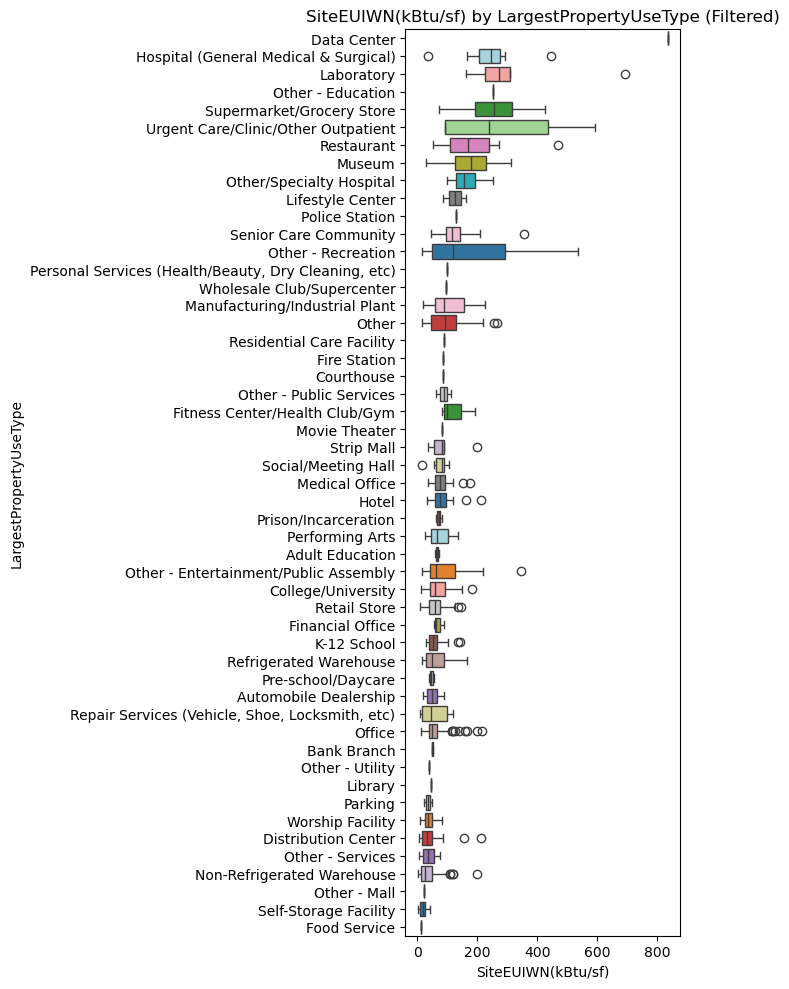

In [91]:
# Calculer l'ordre selon la médiane de SiteEUIWN(kBtu/sf) 
order_energy_filtered = df_one_use_type.groupby('LargestPropertyUseType')['EnergyUseIntensite'].median().sort_values(ascending=False).index

plt.figure(figsize=(7, 10))  
sns.boxplot(
    y='LargestPropertyUseType',
    x='SiteEUIWN(kBtu/sf)',
    data=df_one_use_type,  
    orient='h',
    order=order_energy_filtered, 
    palette="tab20",
    hue='LargestPropertyUseType'
)
plt.title('SiteEUIWN(kBtu/sf) by LargestPropertyUseType (Filtered)')
plt.xlabel('SiteEUIWN(kBtu/sf)')
plt.ylabel('LargestPropertyUseType')
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

In [92]:
def group_Type(type):
    # Data Center
    A = ['Data Center']
    # Hopital
    B = ['Hospital (General Medical & Surgical)', 'Urgent Care/Clinic/Other Outpatient', 'Other/Specialty Hospital'] 
    # Sciences
    C = ['Laboratory', 'Other - Technology/Science']
    # Education
    D = ['Other - Education', 'College/University', 'Pre-school/Daycare', 'K-12 School', 'Adult Education', 'Vocational School'] 
    # Supermarche
    E = ['Supermarket/Grocery Store', 'Wholesale Club/Supercenter'] 
    # Restauration 
    F = ['Restaurant', 'Other - Restaurant/Bar', 'Fast Food Restaurant', 'Food Service']
    # Culture et loisirs
    G = ['Museum', 'Other - Recreation', 'Movie Theater', 'Fitness Center/Health Club/Gym', 'Performing Arts',
         'Other - Entertainment/Public Assembly', 'Social/Meeting Hall', 'Bar/Nightclub', 'Swimming Pool', 'Worship Facility']
    # Services
    H = ['Police Station', 'Courthouse', 'Fire Station', 'Prison/Incarceration', 'Other - Public Services', 'Other - Services',
        'Other - Utility']
    # Résidences
    I = ['Senior Care Community', 'Residential Care Facility', 'Hotel', 'Multifamily Housing', 'Other - Lodging/Residential', 
         'Residence Hall/Dormitory'] 
    # Commerces
    J = ['Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Retail Store', 'Automobile Dealership', 
         'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Library', 'Strip Mall', 'Other - Mall', 'Convenience Store without Gas Station',
         'Food Sales', 'Parking', 'Enclosed Mall']
    # Industrie et entrepôts
    K = ['Manufacturing/Industrial Plant', 'Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse', 
         'Self-Storage Facility']
    # Bureaux
    L = ['Financial Office', 'Medical Office', 'Bank Branch', 'Office', 'Small- and Mid-Sized Office']
    # None
    M = ['None']
 
    if type in A:
        return 'DataCenter'
    elif type in B:
        return 'Hopital'
    elif type in C:
        return 'Sciences'
    elif type in D:
        return 'Education'
    elif type in E:
        return 'Supermarche'
    elif type in F:
        return 'Restauration'
    elif type in G:
        return 'Culture_Loisirs'
    elif type in H:
        return 'Services'
    elif type in I:
        return 'Résidences'
    elif type in J:
        return 'Commerces'
    elif type in K:
        return 'Industrie_entrepots'
    elif type in L:
        return 'Bureaux'
    elif type in M:
        return 'None'
    else:
        return 'Autres'


In [93]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(group_Type)
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].apply(group_Type)
df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].apply(group_Type)

In [94]:
print(df['LargestPropertyUseType'].value_counts())

LargestPropertyUseType
Bureaux                515
Industrie_entrepots    287
Commerces              143
Culture_Loisirs        141
Résidences              97
Autres                  88
Education               77
Supermarche             41
Hopital                 17
Restauration            16
Services                15
Sciences                13
DataCenter               3
Name: count, dtype: int64


In [95]:
print(df['SecondLargestPropertyUseType'].value_counts())

SecondLargestPropertyUseType
None                   657
Commerces              407
Bureaux                170
Autres                  42
Industrie_entrepots     41
Culture_Loisirs         41
Restauration            31
Services                14
Résidences              14
Education               12
DataCenter              12
Sciences                 6
Supermarche              5
Hopital                  1
Name: count, dtype: int64


In [96]:
print(df['ThirdLargestPropertyUseType'].value_counts())

ThirdLargestPropertyUseType
None                   1128
Commerces                85
Bureaux                  65
Restauration             42
Autres                   38
Culture_Loisirs          27
Industrie_entrepots      20
DataCenter               13
Education                13
Résidences               13
Sciences                  4
Services                  3
Hopital                   1
Supermarche               1
Name: count, dtype: int64


### GFA

On vérifie si PropertyGFATotal est supérieur ou égale à la somme de tous les GFA .

In [97]:
def check_property_gfa(row):
    total_gfa_sum = (row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0) + \
                (row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0) + \
                (row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0) + \
                (row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0)

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_sum * 0.8
    upper_bound = total_gfa_sum * 1.2
    
    # Vérifier si ThirdLargestPropertyUseType est None
    if row['ThirdLargestPropertyUseType'] != "None":
        # Si oui, vérifier seulement si PropertyGFATotal est inférieur au lower_bound
        return not (row['PropertyGFATotal'] >= lower_bound)
    else:
        # Sinon, vérifier si PropertyGFATotal est dans la marge de tolérance
        return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 296


In [98]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 
                 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]

PropertyGFATotal  PropertyGFABuilding(s)  PropertyGFAParking  \
59              217603                  217603                   0   
2631             31686                   24328                7358   
1929             34425                   34425                   0   
534              98220                   98220                   0   
1690            591981                  591981                   0   
1025             36070                   36070                   0   
3160             33997                   33997                   0   
1285            130710                   29910              100800   
2442             61580                   34580               27000   
1269             28380                   16200               12180   

              PrimaryPropertyType  LargestPropertyUseTypeGFA  \
59          Senior Care Community                   296313.0   
2631  Small- and Mid-Sized Office                    25927.0   
1929  Small- and Mid-Sized Office                    34425.0   
534                     Warehouse                   129420.0   
1690               Medical Office                   520187.0   
1025                        Other                    66597.0   
3160  Supermarket / Grocery Store                    33997.0   
1285                 Large Office                   120548.0   
2442                        Other                    36280.0   
1269  Small- and Mid-Sized Office                    28380.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
59                      Commerces                              0.0   
2631                    Commerces                           6750.0   
1929          Industrie_entrepots                          15536.0   
534                          None                              NaN   
1690                    Commerces                         282392.0   
1025                         None                              NaN   
3160                    Commerces                          30000.0   
1285                    Commerces                          88960.0   
2442                    Commerces                          23154.0   
1269                         None                              NaN   

      ThirdLargestPropertyUseTypeGFA  
59                               NaN  
2631                          3743.0  
1929                             NaN  
534                              NaN  
1690                         54159.0  
1025                             NaN  
3160                             NaN  
1285                          5436.0  
2442                             NaN  
1269                             NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [99]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Completion à 0

In [100]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.9
    upper_bound = row['PropertyGFATotal'] * 1.1
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [101]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df = df.apply(adjust_gfa_values, axis=1)

#### Calcul

In [102]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    second_largest_gfa = row.get('SecondLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    parking_gfa = row['PropertyGFAParking']
    third_gfa = row.get('ThirdLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    
    # Pour SecondLargestPropertyUseType
    if row['SecondLargestPropertyUseType'] == 'None':
        row['SecondLargestPropertyUseTypeGFA'] = 0

    # Calcul pour ThirdLargestPropertyUseType
    if row['ThirdLargestPropertyUseType'] == 'None':
        third_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa
        if third_gfa_diff > 0:
            row['ThirdLargestPropertyUseType'] = "Autres" 
            row['ThirdLargestPropertyUseTypeGFA'] = third_gfa_diff
            third_gfa = third_gfa_diff  # Mise à jour de third_gfa
        else:
            row['ThirdLargestPropertyUseTypeGFA'] = 0

    # Vérification pour une différence restante après ThirdLargestPropertyUseType
    remaining_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa - third_gfa
    if remaining_gfa_diff > 0:
        row['FourthLargestPropertyUseType'] = "Autres" 
        row['FourthLargestPropertyUseTypeGFA'] = remaining_gfa_diff
    else:
        row['FourthLargestPropertyUseType'] = "None" 
        row['FourthLargestPropertyUseTypeGFA'] = 0
    

    return row


In [103]:
# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df = df.apply(fill_missing_types_and_calculate_gfa, axis=1)

#### Feature engineering

In [104]:
# Extraire les types et leurs GFA respectifs
types_columns = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'FourthLargestPropertyUseType']
gfa_columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseTypeGFA']

# Applatir le tableau et identifier tous les types d'utilisation uniques pour préparer les nouvelles colonnes
types_uniques = pd.unique(df[types_columns].values.ravel('K'))

# Initialiser les nouvelles colonnes pour chaque type unique dans le DataFrame original
for type_unique in types_uniques:
    if type_unique and type_unique != 'None':  # Ignorer les valeurs nulles ou 'None'
        df[f'GFA_{type_unique}'] = 0.0

# Parcourir chaque ligne et assigner les valeurs de GFA aux nouvelles colonnes
for index, row in df.iterrows():
    for type_col, gfa_col in zip(types_columns, gfa_columns):
        type_value = row[type_col]
        gfa_value = row[gfa_col]
        if type_value and type_value != 'None':  # S'assurer que le type est valide
            df.at[index, f'GFA_{type_value}'] += gfa_value

In [105]:
df.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
6             10      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
6                   Camlin  1619 9th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
6                    0660000825                    7     DOWNTOWN  47.61390   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   

   PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
0                   0                   88434             Résidences   
1               15064                   88502             Résidences   
2              196718                  759392             Résidences   
3                   0                   61320             Résidences   
6                   0                   83008             Résidences   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0                    Commerces   
2                   756493.0                         None   
3                    61320.0                         None   
6                    81352.0                         None   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                        None   
1                          15064.0                Restauration   
2                              0.0                      Autres   
3                              0.0                        None   
6                              0.0                      Autres   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                          2899.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
6                          1656.0                      NaN             27.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           83.661424          176.100006   
2         96.000000           77.331177          241.899994   
3        110.800003          113.300003          216.199997   
6         70.800003           74.500000          146.600006   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006  

Vérification des outliers

In [106]:
# Liste des types
gfa_types = ['Résidences', 'Culture_Loisirs', 'Services', 'Autres', 'Education', 'Commerces', 'Bureaux', 'Industrie_entrepots', 
             'Hopital', 'Supermarche', 'Sciences', 'Restauration', 'DataCenter']  

data_for_median = []
df_int_type = df.copy()

# Itérer sur chaque type de GFA pour calculer l'intensité d'énergie spécifique
for gfa_type in gfa_types:
    column_name = 'GFA_' + gfa_type
    # Calculer l'intensité d'énergie pour le type de GFA actuel
    df_int_type[column_name + '_Energy_Intensity'] = (df_int_type['SiteEUIWN(kBtu/sf)'] * df_int_type[column_name]) / df_int_type['PropertyGFATotal']
    
    # Créer une structure intermédiaire pour stocker les résultats
    for index, row in df_int_type.iterrows():
        if row[column_name] > 0:  
            data_for_median.append({'Type': gfa_type, 'Energy_Intensity': row[column_name + '_Energy_Intensity']})

df_energy_intensity_by_type = pd.DataFrame(data_for_median)

# Calculer la médiane de l'intensité d'énergie pour chaque type de GFA
medians_by_type = df_energy_intensity_by_type.groupby('Type')['Energy_Intensity'].median().reset_index()

# Afficher les médianes de l'intensité d'énergie par type de GFA
print(medians_by_type)

                   Type  Energy_Intensity
0                Autres          4.410139
1               Bureaux         32.558778
2             Commerces         12.015061
3       Culture_Loisirs         37.814336
4            DataCenter          1.258547
5             Education         44.350000
6               Hopital        169.321766
7   Industrie_entrepots         22.192225
8          Restauration          5.655562
9            Résidences         56.500000
10             Sciences         52.206694
11             Services         20.074502
12          Supermarche        208.093798


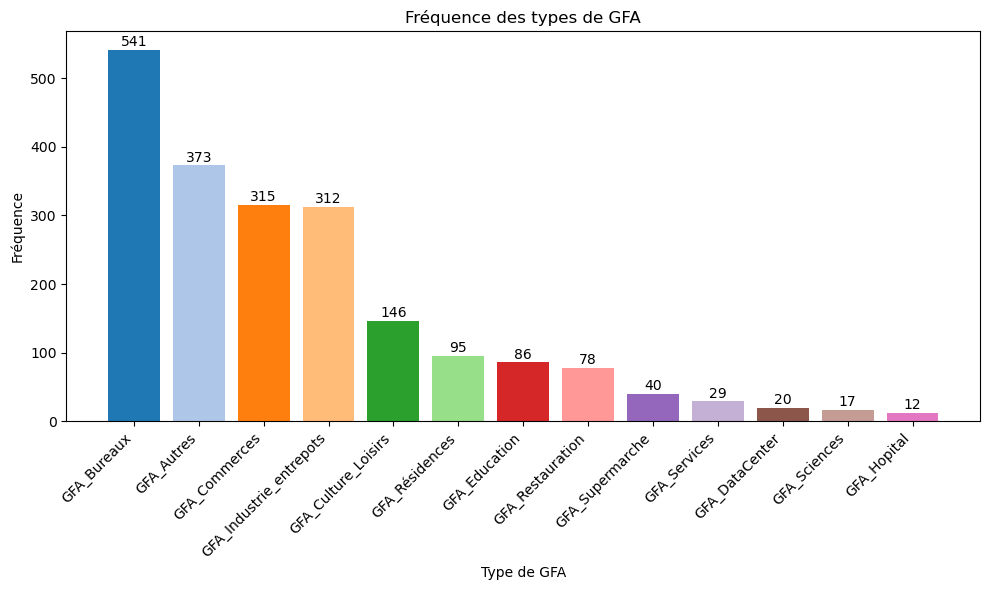

In [107]:
# Calculer la fréquence des valeurs non nulles pour chaque GFA
gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
gfa_frequencies = {col: (df[col] > 0).sum() for col in gfa_columns}

# série décroissante
gfa_frequencies_series = pd.Series(gfa_frequencies).sort_values(ascending=False)

# Créer le bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(gfa_frequencies_series.index, gfa_frequencies_series.values, color=plt.cm.tab20(range(len(gfa_frequencies_series))))

# Ajouter le nombre en haut de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Fréquence des types de GFA')
plt.xlabel('Type de GFA')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [108]:
outliers = find_outliers(df_int_type, 'GFA_DataCenter_Energy_Intensity', 1.5)
if not outliers.empty:
    display(outliers[['GFA_DataCenter_Energy_Intensity', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

GFA_DataCenter_Energy_Intensity LargestPropertyUseType  \
15                           0.118362              Commerces   
44                           0.165101                Bureaux   
76                           4.950002                Bureaux   
106                          8.594243                Bureaux   
234                          0.142227                Bureaux   
240                        834.400024             DataCenter   
328                         53.595873                Bureaux   
333                          1.267826               Sciences   
471                          0.116081                Bureaux   
489                          1.249268                Bureaux   
491                          3.113751                Bureaux   
524                          3.467972                Bureaux   
527                          0.158549                Bureaux   
558                        326.298664             DataCenter   
574                          0.056844                Bureaux   
591                          0.378826                Bureaux   
1262                        22.984141                Bureaux   
1329                         0.376426                Bureaux   
1405                        46.783514                Bureaux   
1668                         0.857501                Bureaux   

     SecondLargestPropertyUseType  
15                      Commerces  
44                      Commerces  
76                     DataCenter  
106                    DataCenter  
234                        Autres  
240                          None  
328                    DataCenter  
333                    DataCenter  
471                    DataCenter  
489                    DataCenter  
491                    DataCenter  
524                    DataCenter  
527                     Commerces  
558                       Bureaux  
574                     Commerces  
591                    DataCenter  
1262                       Autres  
1329                   DataCenter  
1405                   DataCenter  
1668          Industrie_entrepots

In [109]:
df = df[df['GFA_DataCenter'] == 0]
df.drop(columns=['GFA_DataCenter'], inplace=True)

## Résultats du nettoyage

In [110]:
df.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
6             10      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
6                   Camlin  1619 9th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
6                    0660000825                    7     DOWNTOWN  47.61390   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
6 -122.33283                1.0              11             83008   

   PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
0                   0                   88434             Résidences   
1               15064                   88502             Résidences   
2              196718                  759392             Résidences   
3                   0                   61320             Résidences   
6                   0                   83008             Résidences   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0                    Commerces   
2                   756493.0                         None   
3                    61320.0                         None   
6                    81352.0                         None   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                        None   
1                          15064.0                Restauration   
2                              0.0                      Autres   
3                              0.0                        None   
6                              0.0                      Autres   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                          2899.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
6                          1656.0                      NaN             27.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           83.661424          176.100006   
2         96.000000           77.331177          241.899994   
3        110.800003          113.300003          216.199997   
6         70.800003           74.500000          146.600006   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006  

Maintenant que le traitement des valeurs abérrantes et manquante a été fait, on peut supprimer les colonnes qui ne nous servirons pas pour nos modèles.

In [111]:
cols_to_drop = ['OSEBuildingID', 'DataYear', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State',
                'ZipCode', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'Comments',
                'Latitude', 'Longitude', 'Electricity(kWh)', 'NaturalGas(therms)', 'Outlier', 
                'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseType', 
                'FourthLargestPropertyUseTypeGFA']

df_selected = df.drop(columns=cols_to_drop).copy()

In [112]:
df_selected.shape

(1137, 28)

In [113]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.29 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

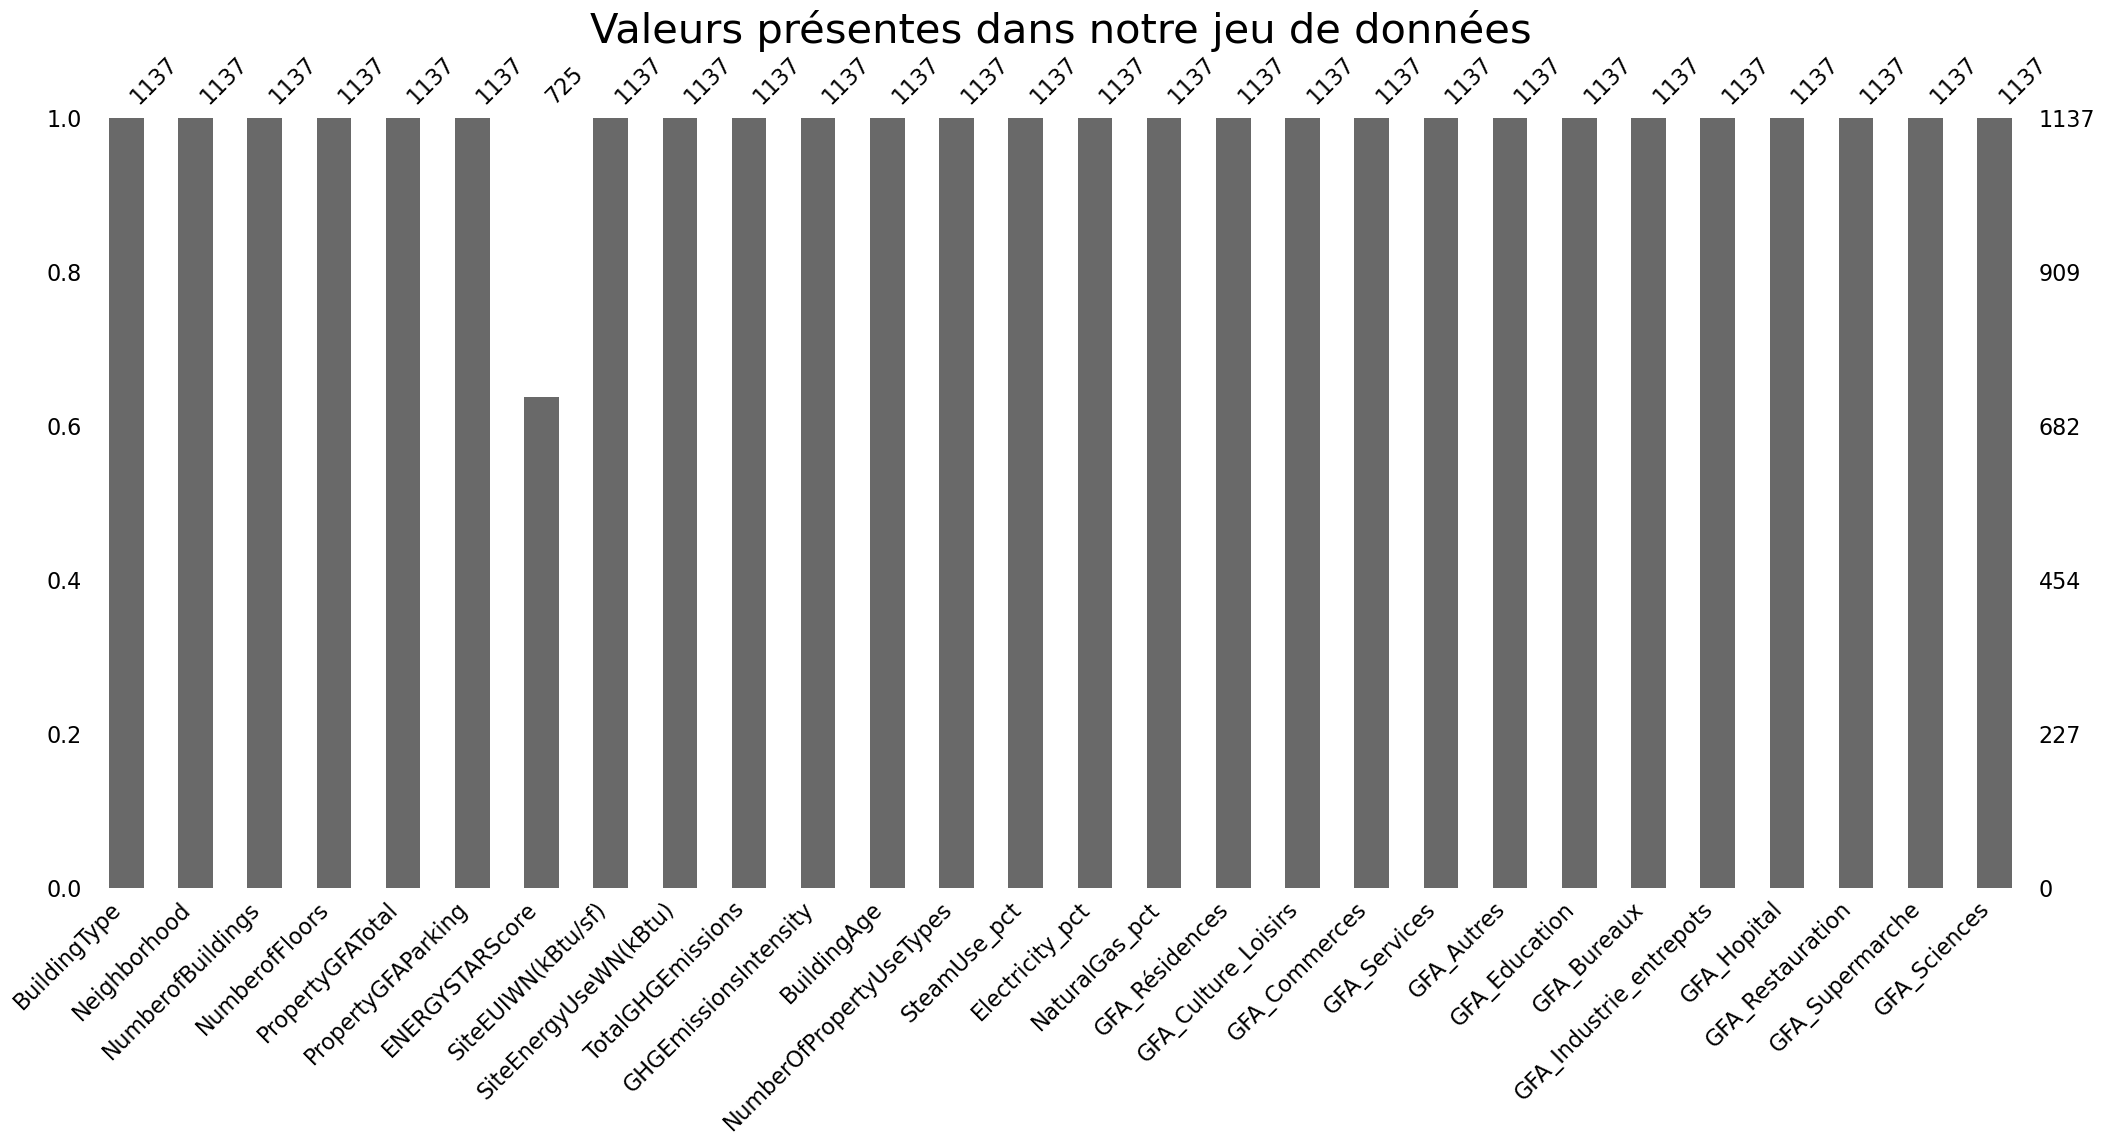

In [114]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_selected)

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

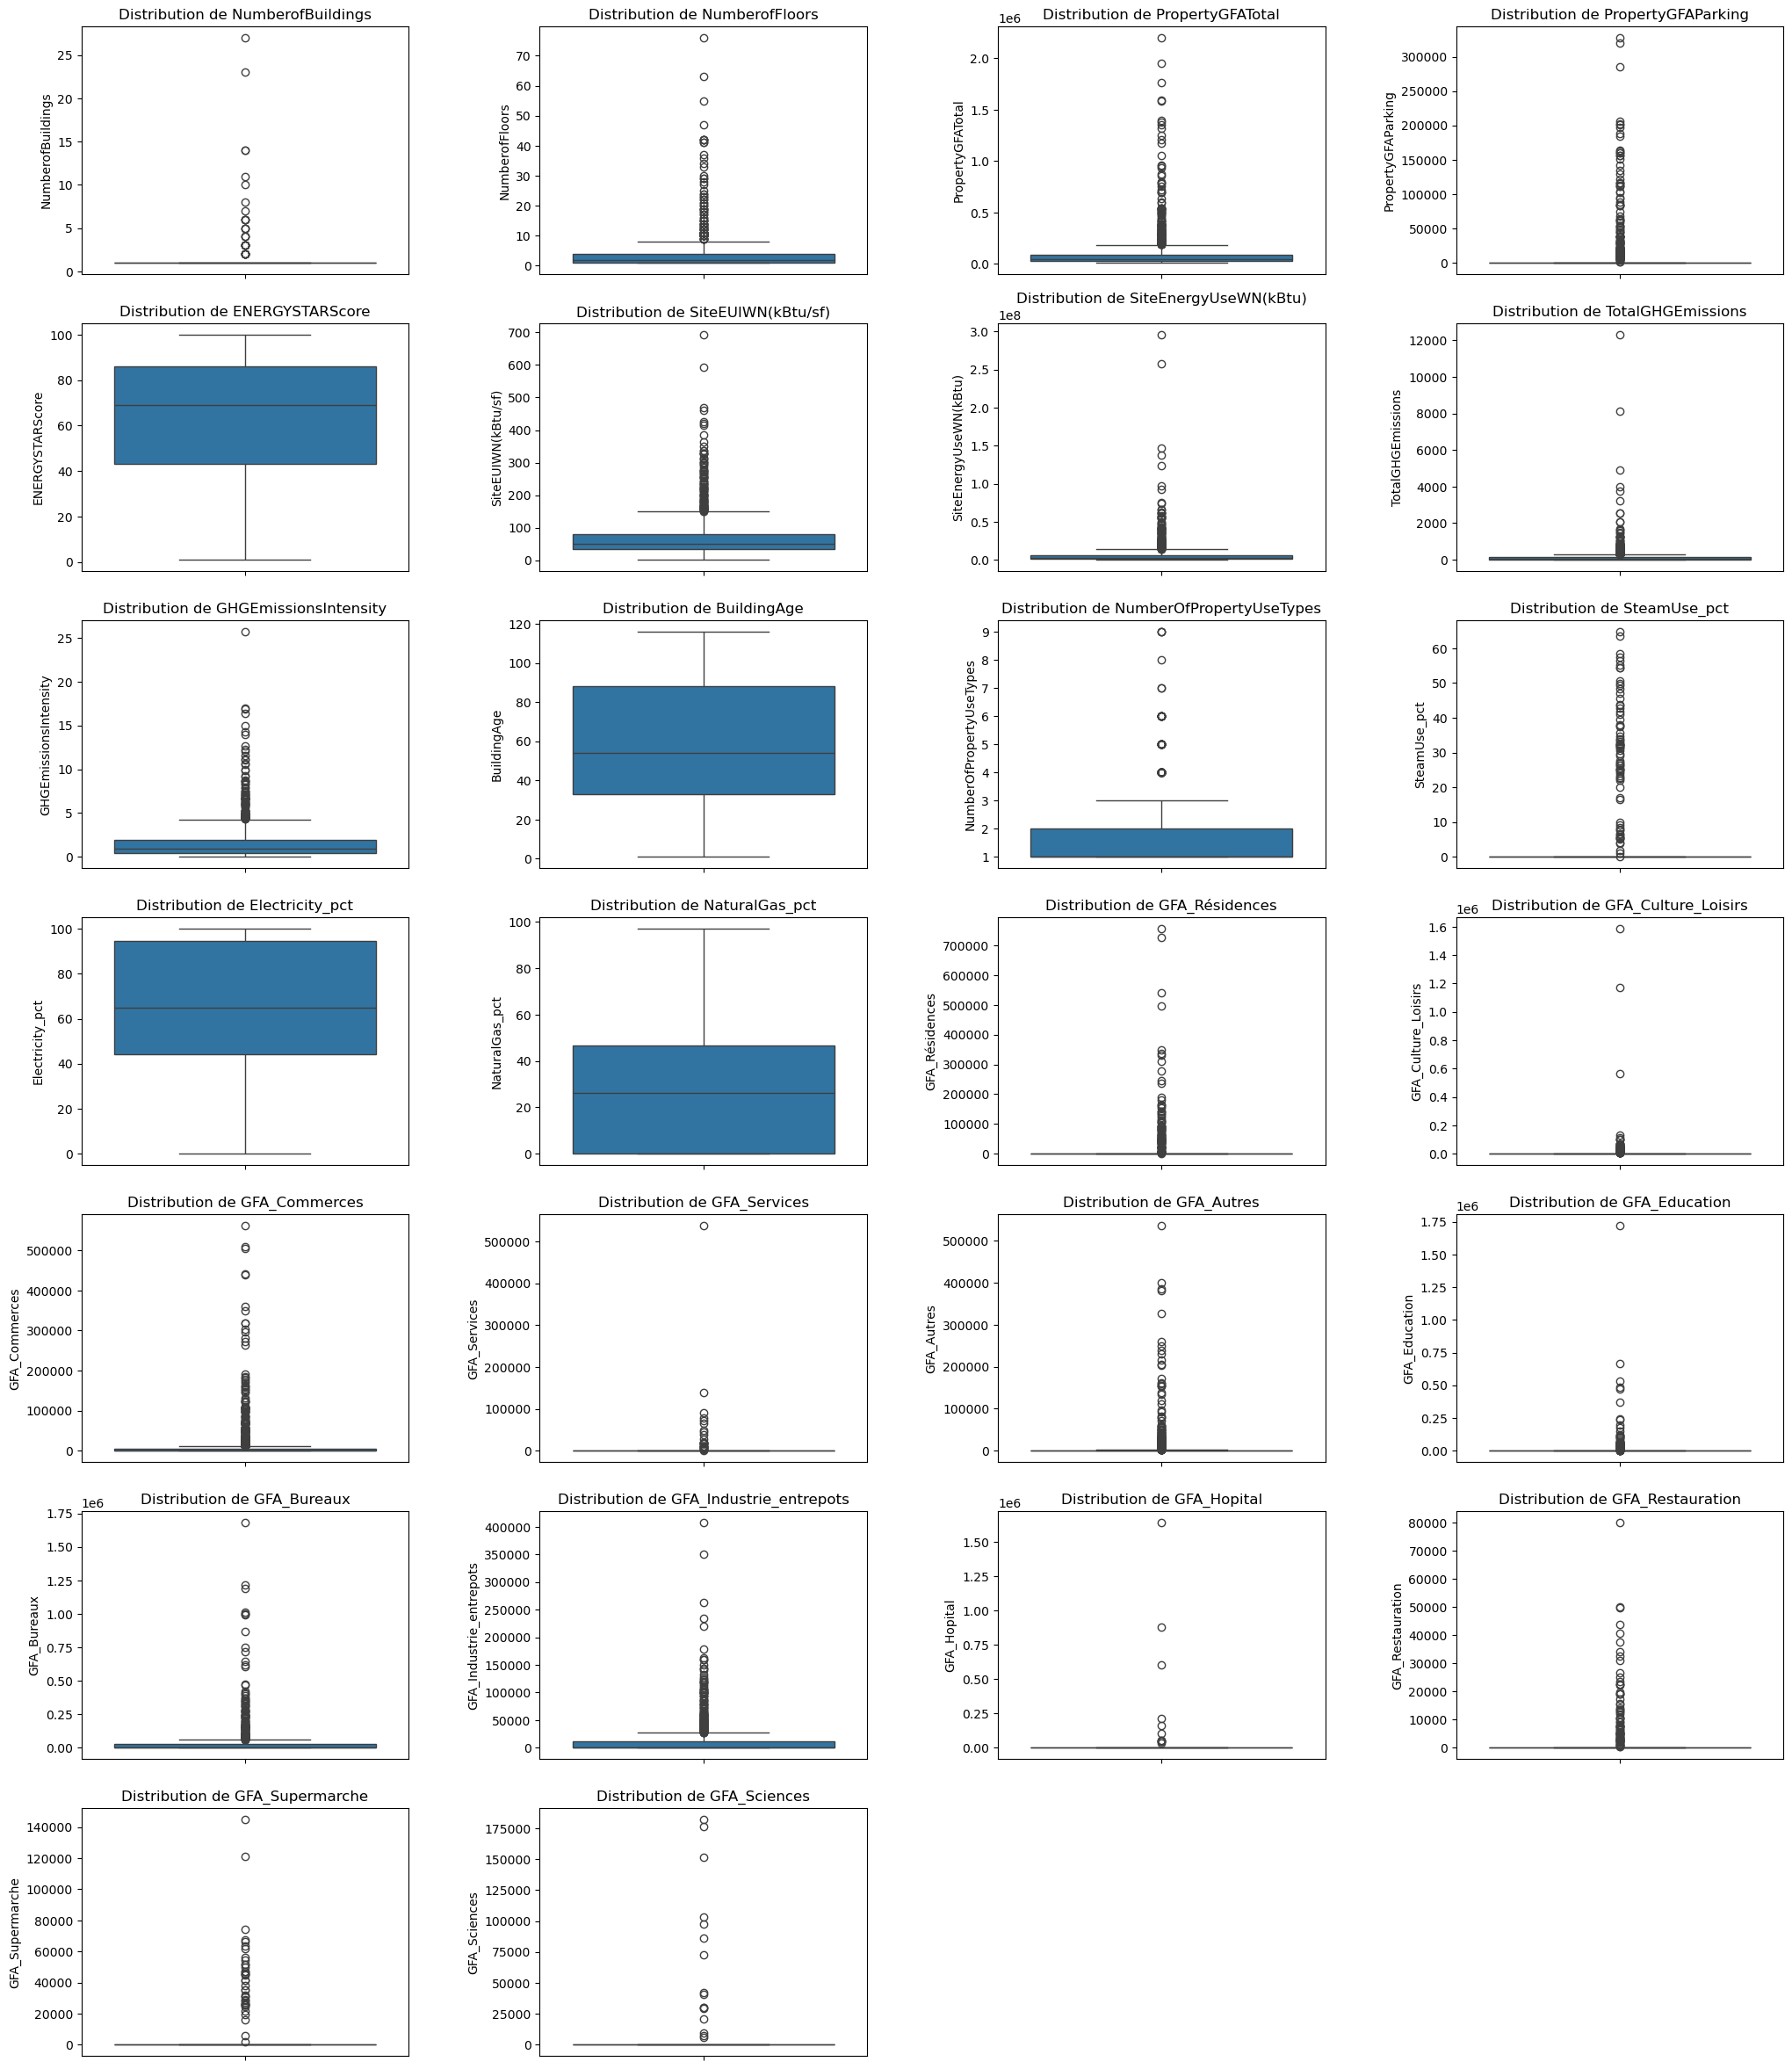

In [115]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(25,30))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_selected[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [116]:
df_selected.describe()

NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        1137.000000     1137.000000      1.137000e+03   
mean            1.151275        3.884785      1.032852e+05   
std             1.311508        6.117102      1.950220e+05   
min             1.000000        1.000000      1.128500e+04   
25%             1.000000        1.000000      2.780000e+04   
50%             1.000000        2.000000      4.441600e+04   
75%             1.000000        4.000000      8.955000e+04   
max            27.000000       76.000000      2.200000e+06   

       PropertyGFAParking  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
count         1137.000000       725.000000         1137.000000   
mean          6855.830255        62.193103           70.099634   
std          29015.667144        28.649987           67.253925   
min              0.000000         1.000000            1.500000   
25%              0.000000        43.000000           33.799999   
50%              0.000000        69.000000           51.091376   
75%              0.000000        86.000000           80.123932   
max         327680.000000       100.000000          693.099976   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
count           1.137000e+03        1137.000000            1137.000000   
mean            7.112051e+06         158.698558               1.626359   
std             1.691653e+07         545.111768               2.201145   
min             5.811420e+04           0.400000               0.010000   
25%             1.221954e+06          19.430000               0.400000   
50%             2.484502e+06          46.610000               0.920000   
75%             6.505995e+06         130.560000               1.950000   
max             2.959299e+08       12307.160000              25.710000   

       BuildingAge  NumberOfPropertyUseTypes  SteamUse_pct  Electricity_pct  \
count  1137.000000               1137.000000   1137.000000      1137.000000   
mean     57.189974                  1.852243      1.899256        65.856392   
std      31.986531                  1.181271      8.377729        26.808368   
min       1.000000                  1.000000      0.000000         0.000000   
25%      33.000000                  1.000000      0.000000        44.196752   
50%      54.000000                  1.000000      0.000000        64.868714   
75%      88.000000                  2.000000      0.000000        94.648453   
max     116.000000                  9.000000     64.773098       100.000000   

       NaturalGas_pct  GFA_Résidences  GFA_Culture_Loisirs  GFA_Commerces  \
count     1137.000000     1137.000000         1.137000e+03    1137.000000   
mean        27.028688     8708.555849         6.654668e+03   14083.958839   
std         23.844485    48792.691550         6.184276e+04   49140.637100   
min          0.000000        0.000000         0.000000e+00       0.000000   
25%          0.000000        0.000000         0.000000e+00       0.000000   
50%         26.287188        0.000000         0.000000e+00       0.000000   
75%         46.834479        0.000000         0.000000e+00    4200.000000   
max         97.077764   756493.000000         1.585960e+06  561684.000000   

        GFA_Services     GFA_Autres  GFA_Education   GFA_Bureaux  \
count    1137.000000    1137.000000   1.137000e+03  1.137000e+03   
mean     1195.993843    7865.858839   7.161197e+03  3.672076e+04   
std     17301.978958   36368.203022   6.368523e+04  1.198569e+05   
min         0.000000       0.000000   0.000000e+00  0.000000e+00   
25%         0.000000       0.000000   0.000000e+00  0.000000e+00   
50%         0.000000       0.000000   0.000000e+00  0.000000e+00   
75%         0.000000    1119.000000   0.000000e+00  2.500000e+04   
max    537150.000000  535947.000000   1.719643e+06  1.680937e+06   

       GFA_Industrie_entrepots   GFA_Hopital  GFA_Restauration  \
count              1137.000000  1.137000e+03       1137.000000   
mean              12556.867194  3.4

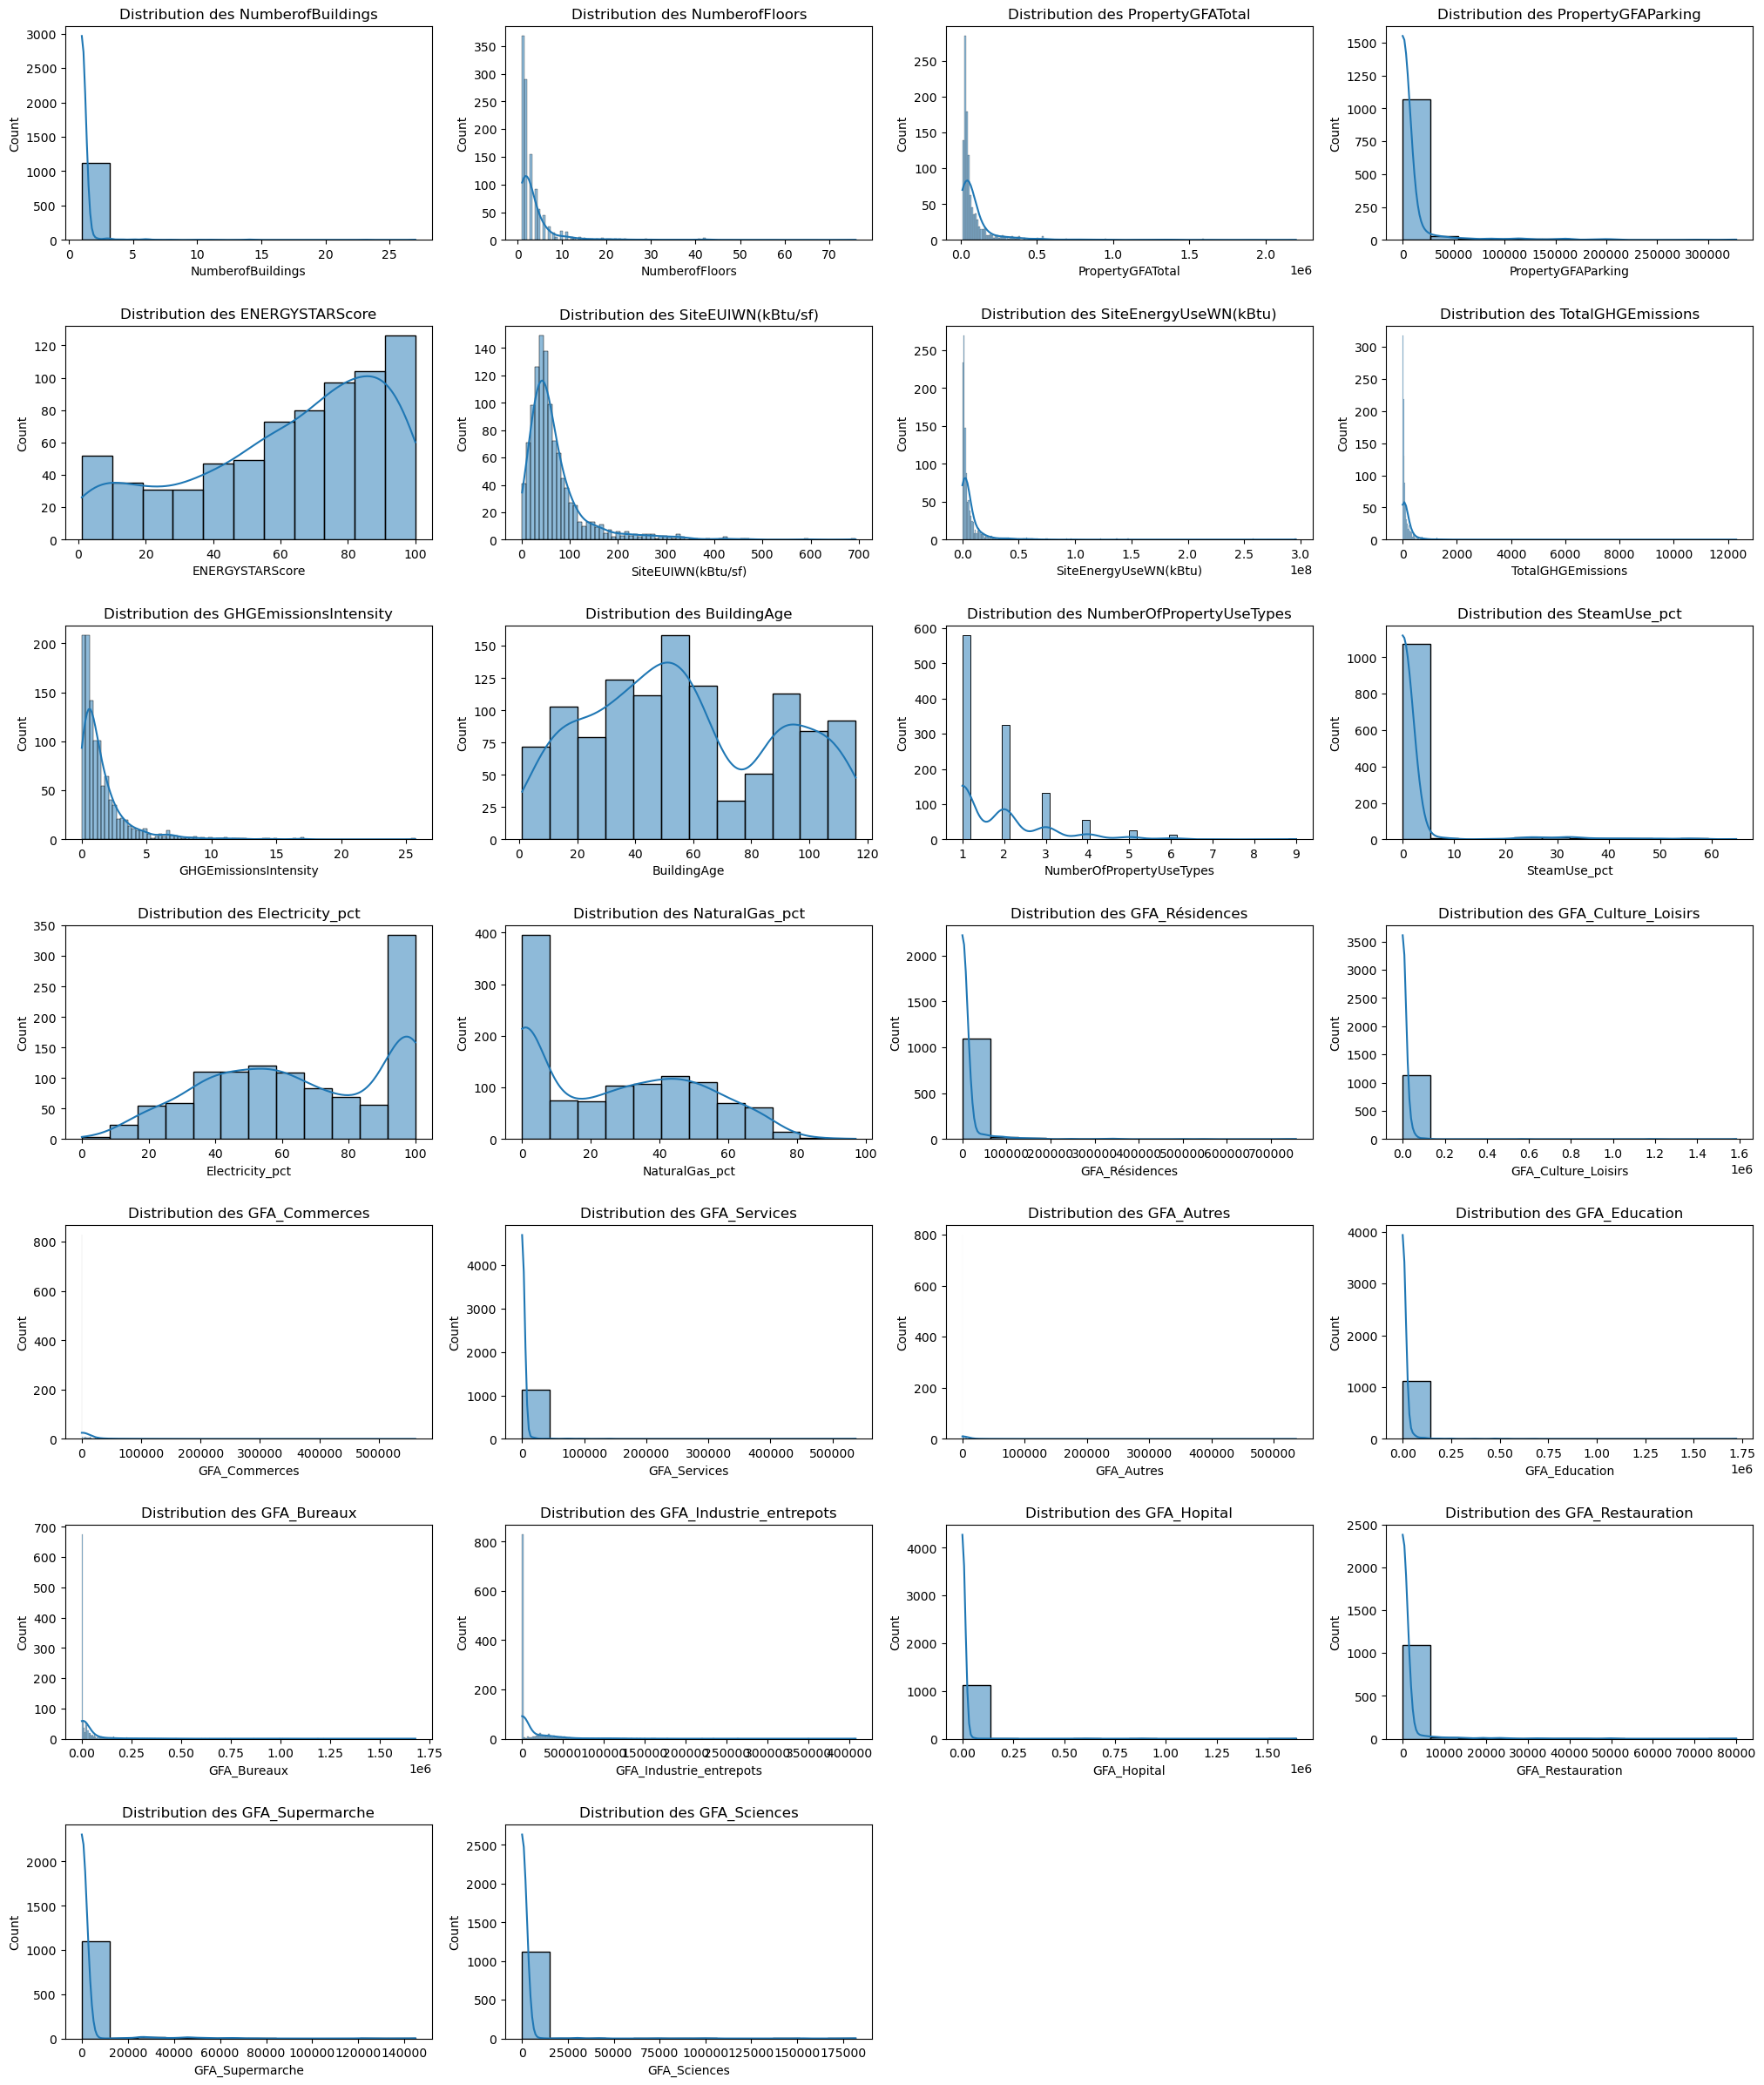

In [117]:
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(25,30))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.histplot(data=df_selected, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [118]:
# Compter le nombre de valeurs zéro ou négatives dans 'TotalGHGEmissions'
count_zero_neg_ghg = len(df_selected[df_selected['TotalGHGEmissions'] <= 0])

# Compter le nombre de valeurs zéro ou négatives dans 'SiteEnergyUse(kBtu)'
count_zero_neg_energy = len(df_selected[df_selected['SiteEnergyUseWN(kBtu)'] <= 0])

# Afficher les résultats
print(f"Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': {count_zero_neg_ghg}")
print(f"Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': {count_zero_neg_energy}")

Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': 0
Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': 0


In [119]:
# Calculer le logarithme des colonnes 'TotalGHGEmissions' et 'SiteEnergyUseWN(kBtu)'
df_selected = df_selected.copy()
df_selected['Log_TotalGHGEmissions'] = np.log(df_selected['TotalGHGEmissions'])
df_selected['Log_SiteEnergyUseWN'] = np.log(df_selected['SiteEnergyUseWN(kBtu)'])

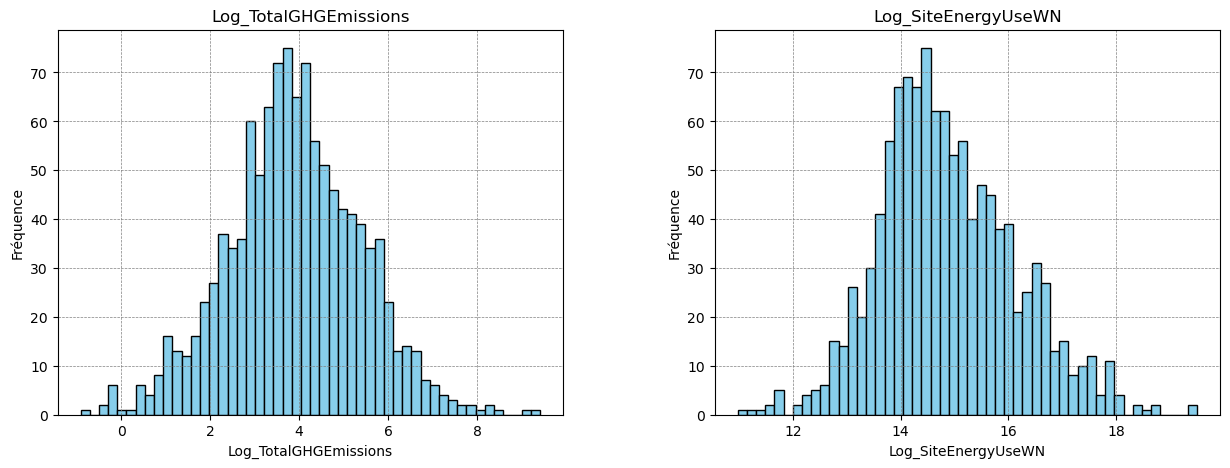

In [120]:
# Créez un histogramme pour TotalGHGEmissions et SiteEnergyUse(kBtu)
# Sélection des colonnes spécifiques
selected_columns = df_selected[['Log_TotalGHGEmissions','Log_SiteEnergyUseWN']]

# Créez un histogramme pour chaque variable numérique sélectionnée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, column in zip(axes, selected_columns.columns):
    ax.hist(df_selected[column], bins=50, edgecolor='black', color='skyblue')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')
    # Ajouter un quadrillage
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
# Ajustez l'espace entre les subplots
plt.subplots_adjust(wspace=0.3)

# Affichez les histogrammes
plt.show()

### Variables catégorielles

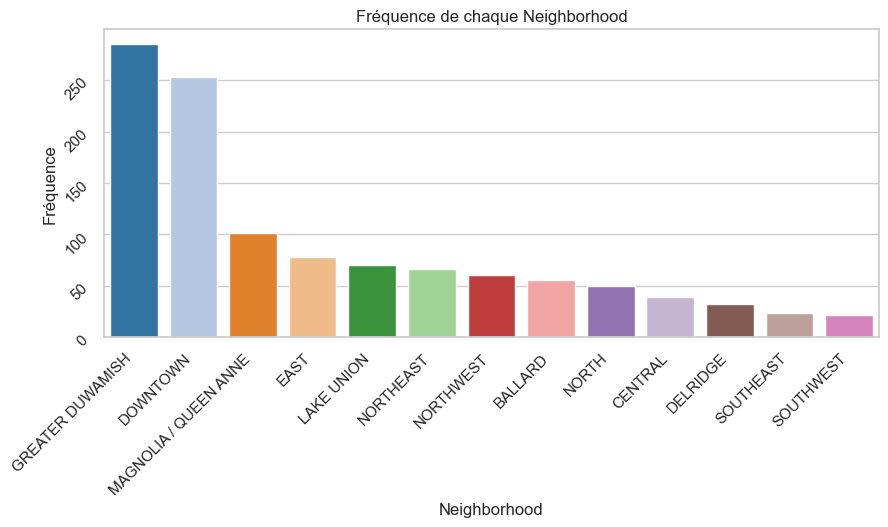

In [121]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df_selected['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

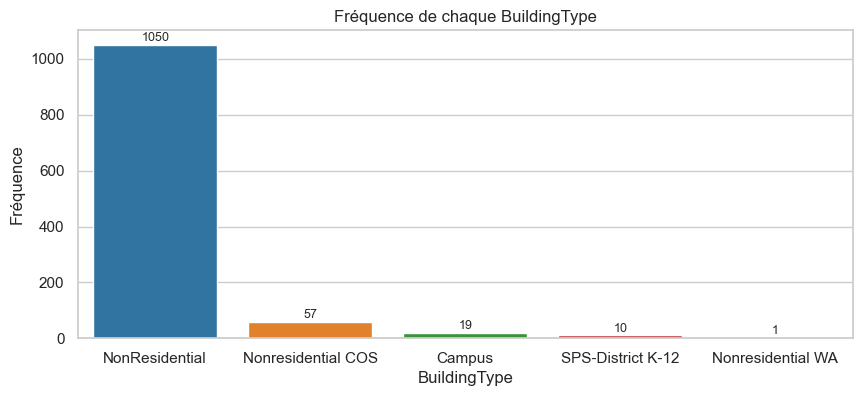

In [122]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df_selected['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
barplot = sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

# Itérer sur les barres pour afficher le nombre d'occurrences
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=9, xytext = (0, 5), 
                     textcoords = 'offset points')

plt.show()

La distribution des catégories est largement  déséquilibrée cce qui peut influencer la performance de nos modèles de ML, car les modèles pourraient être biaisés en faveur de la classe majoritaire. Il vaut mieux ne pas la considérer dans nos modèles et la supprimer.

In [123]:
df_selected = df_selected.drop(columns=['BuildingType'])

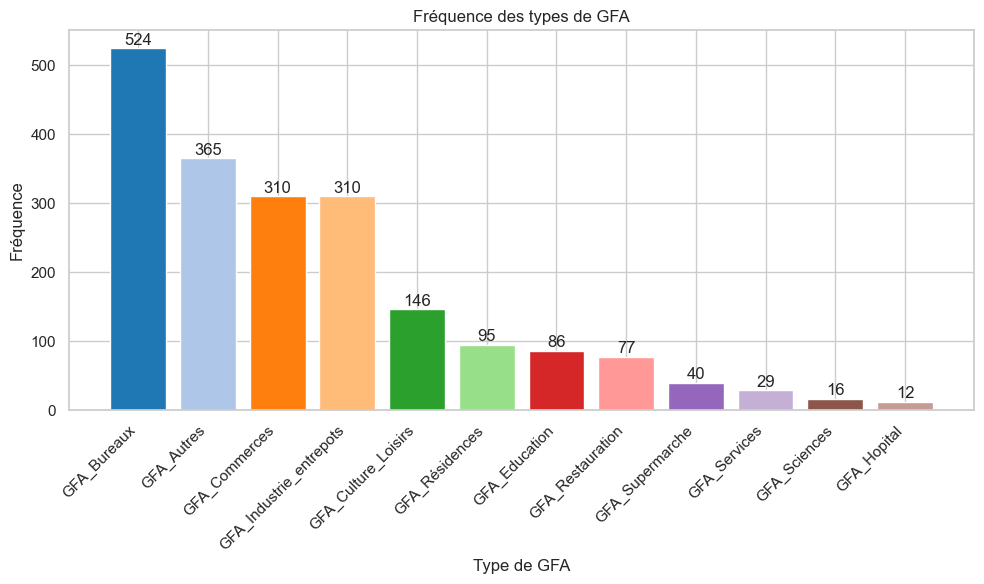

In [124]:
# Calculer la fréquence des valeurs non nulles pour chaque GFA
gfa_columns = [col for col in df_selected.columns if col.startswith('GFA_')]
gfa_frequencies = {col: (df_selected[col] > 0).sum() for col in gfa_columns}

# série décroissante
gfa_frequencies_series = pd.Series(gfa_frequencies).sort_values(ascending=False)

# Créer le bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(gfa_frequencies_series.index, gfa_frequencies_series.values, color=plt.cm.tab20(range(len(gfa_frequencies_series))))

# Ajouter le nombre en haut de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Fréquence des types de GFA')
plt.xlabel('Type de GFA')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [125]:
gfa_frequencies_series

GFA_Bureaux                524
GFA_Autres                 365
GFA_Commerces              310
GFA_Industrie_entrepots    310
GFA_Culture_Loisirs        146
GFA_Résidences              95
GFA_Education               86
GFA_Restauration            77
GFA_Supermarche             40
GFA_Services                29
GFA_Sciences                16
GFA_Hopital                 12
dtype: int64

## Analyse Bivariée

### Variables numériques

In [126]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df_selected.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df_selected[numerics_col])

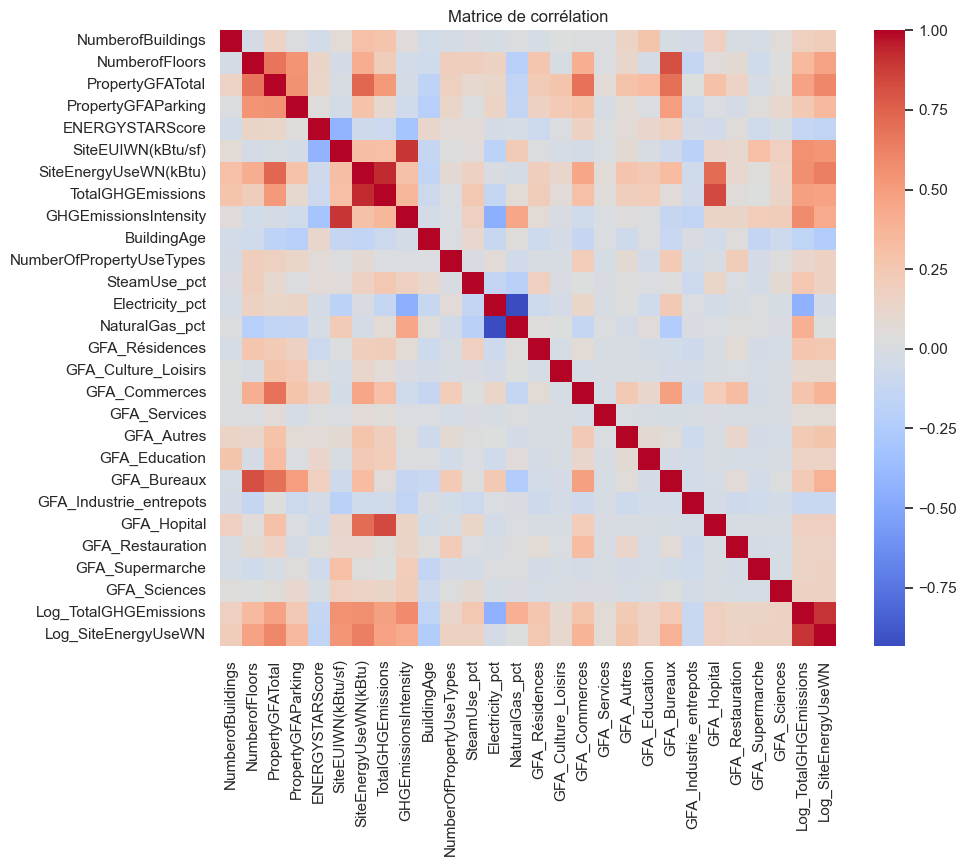

In [127]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

### Variables catégorielles

In [128]:
def plot_boxplots_by_category(df, category):
    sns.set(style="whitegrid")
    

    # Lignes en fonction du nombre de catégories
    num_categories = len(df[category].unique())
    height_per_subplot = 3
    total_height = (num_categories * height_per_subplot) / 10

    # 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, total_height), constrained_layout=True)
    axes = axes.flatten()

    # Orderby median de SiteEnergyUseWN(kBtu)
    order_energy = df.groupby(category)['SiteEUIWN(kBtu/sf)'].median().sort_values(ascending=False).index
    # SiteEnergyUseWN(kBtu) boxplot
    sns.boxplot(y=category, x='SiteEUIWN(kBtu/sf)', data=df, orient='h', ax=axes[0], order=order_energy, hue=category, palette="tab20")
    axes[0].set_title(f'SiteEUIWN(kBtu/sf) by {category}')
    axes[0].set_xlabel('SiteEUIWN(kBtu/sf)')
    axes[0].set_ylabel(category)

    # Orderby median de  TotalGHGEmissions
    order_ghg = df.groupby(category)['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
    # TotalGHGEmissions boxplot
    sns.boxplot(y=category, x='GHGEmissionsIntensity', data=df, orient='h', ax=axes[1], order=order_ghg, hue=category, palette="tab20")
    axes[1].set_title(f'GHGEmissionsIntensity by {category}')
    axes[1].set_xlabel('GHGEmissionsIntensity')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()

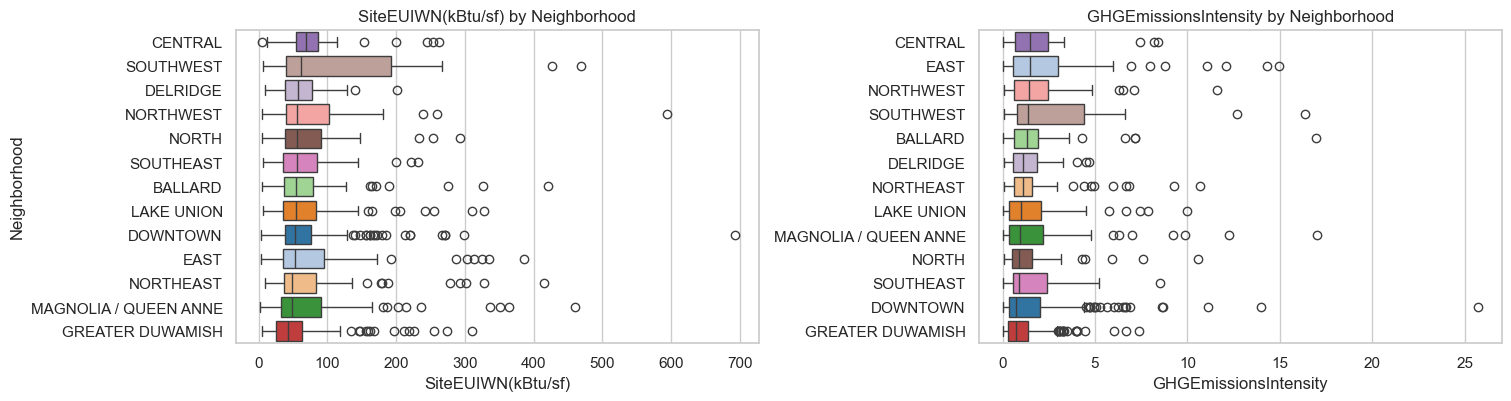

In [129]:
categorical_columns = ['Neighborhood']
for category in categorical_columns:
    plot_boxplots_by_category(df_selected, category)

## Analyse Multivariée (ANOVA)

In [130]:
def perform_anova_tukey(df, numeric_var, categorical_var):
    # Effectuez l'ANOVA
    formula = f"{numeric_var} ~ C({categorical_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Effectuez le test de Tukey pour les comparaisons post-hoc
    tukey_result = pairwise_tukeyhsd(endog=df[numeric_var], groups=df[categorical_var], alpha=0.05)
    
    # Affichez les résultats
    print(f"ANOVA Table for {numeric_var} by {categorical_var}:")
    print(anova_table)
    print("\n")
    print(f"\nTukey's HSD Results for {numeric_var} by {categorical_var}:")
    print(tukey_result)

In [131]:
# Renommer la colonne pour ne pas avoir de probleme avec les caracteres spéciaux
df_selected.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)

### Neighborhood

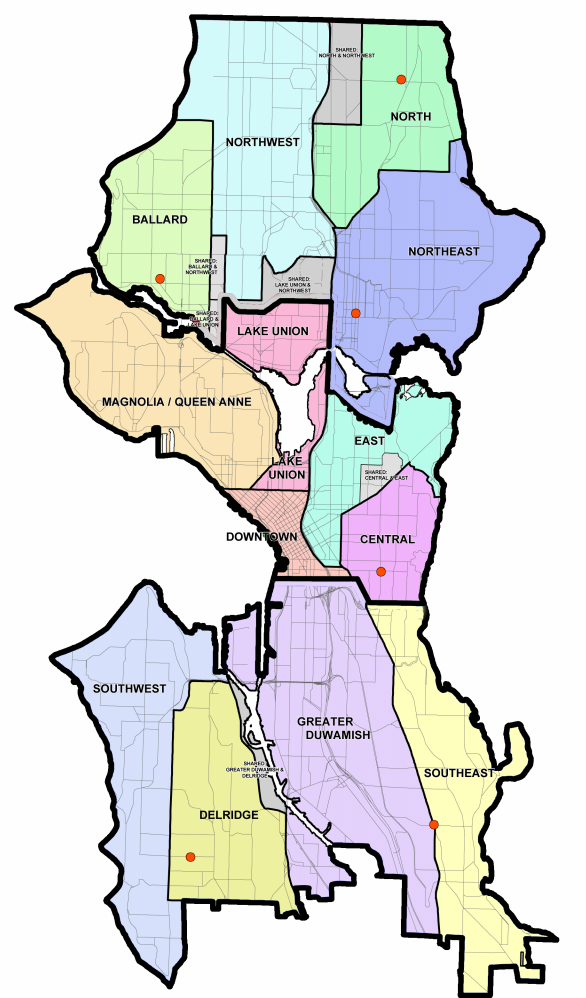

In [132]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [133]:
perform_anova_tukey(df_selected, 'SiteEUIWN_kBtu_sf', 'Neighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by Neighborhood:
                       sum_sq      df         F    PR(>F)
C(Neighborhood)  1.948555e+05    12.0  3.692105  0.000018
Residual         4.943375e+06  1124.0       NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by Neighborhood:
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
              BALLARD               CENTRAL    8.621    1.0 -37.2983  54.5402  False
              BALLARD              DELRIDGE -11.6878 0.9999 -60.4779  37.1023  False
              BALLARD              DOWNTOWN  -7.8172 0.9999 -40.3322  24.6979  False
              BALLARD                  EAST   7.3192    1.0 -31.2438  45.8821  False
              BALLARD      GREATER DUWAMISH  -23.081 0.4582 -55.2635   9.1016  False
              BALLARD            

Les différences semblent plus provenir du type de bâtiment dans ces quartiers que vraiment des quartiers en eux-même. Il faut retirer cette variable pour créer nos modèles. (à tester)

In [134]:
df_selected = df_selected.drop(columns=['Neighborhood'])

### PropertyUseType

#### Energy

In [135]:
df_selected.head(1)

NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   

   ENERGYSTARScore  SiteEUIWN_kBtu_sf  SiteEnergyUseWN(kBtu)  \
0             60.0          84.300003              7456910.0   

   TotalGHGEmissions  GHGEmissionsIntensity  BuildingAge  \
0             249.98                   2.83           89   

   NumberOfPropertyUseTypes  SteamUse_pct  Electricity_pct  NaturalGas_pct  \
0                         1      26.87282        52.917723        17.11772   

   GFA_Résidences  GFA_Culture_Loisirs  GFA_Commerces  GFA_Services  \
0         88434.0                  0.0            0.0           0.0   

   GFA_Autres  GFA_Education  GFA_Bureaux  GFA_Industrie_entrepots  \
0         0.0            0.0          0.0                      0.0   

   GFA_Hopital  GFA_Restauration  GFA_Supermarche  GFA_Sciences  \
0          0.0               0.0              0.0           0.0   

   Log_TotalGHGEmissions  Log_SiteEnergyUseWN  
0               5.521381            15.824652

In [136]:
# Liste des types
gfa_types = ['Résidences', 'Culture_Loisirs', 'Services', 'Autres', 'Education', 'Commerces', 'Bureaux', 'Industrie_entrepots', 
             'Hopital', 'Supermarche', 'Sciences', 'Restauration']

data_for_median = []
df_med_int_type = df_selected.copy()

# Itérer sur chaque type de GFA pour calculer l'intensité d'énergie spécifique
for gfa_type in gfa_types:
    column_name = 'GFA_' + gfa_type
    # Calculer l'intensité d'énergie pour le type de GFA actuel
    df_med_int_type[column_name + '_Energy_Intensity'] = (df_med_int_type['SiteEUIWN_kBtu_sf'] * df_med_int_type[column_name]) / df_med_int_type['PropertyGFATotal']
    
    # Créer une structure intermédiaire pour stocker les résultats
    for index, row in df_med_int_type.iterrows():
        if row[column_name] > 0:  
            data_for_median.append({'Type': gfa_type, 'Energy_Intensity': row[column_name + '_Energy_Intensity']})

df_energy_intensity_by_type = pd.DataFrame(data_for_median)

# Calculer la médiane de l'intensité d'énergie pour chaque type de GFA
medians_by_type = df_energy_intensity_by_type.groupby('Type')['Energy_Intensity'].median().reset_index()

# Afficher les médianes de l'intensité d'énergie par type de GFA
print(medians_by_type)

                   Type  Energy_Intensity
0                Autres          4.201267
1               Bureaux         32.156910
2             Commerces         12.045859
3       Culture_Loisirs         37.814336
4             Education         44.350000
5               Hopital        169.321766
6   Industrie_entrepots         22.192225
7          Restauration          5.750451
8            Résidences         56.500000
9              Sciences         43.767581
10             Services         20.074502
11          Supermarche        208.093798


# Export des données

In [137]:
# Suppression des dernières fuites de données
df_selected.drop(columns=['SiteEUIWN_kBtu_sf','GHGEmissionsIntensity', 'PropertyGFATotal'], inplace=True)

In [138]:
df_selected.shape

(1137, 25)

In [139]:
path     = "data/cleaned/"
filename = "df_cleaned.csv"

In [140]:
df_selected.to_csv(path+filename, index=False)

In [141]:
df_selected.head(5)

NumberofBuildings  NumberofFloors  PropertyGFAParking  ENERGYSTARScore  \
0                1.0              12                   0             60.0   
1                1.0              11               15064             61.0   
2                1.0              41              196718             43.0   
3                1.0              10                   0             56.0   
6                1.0              11                   0             27.0   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  BuildingAge  \
0              7456910.0             249.98           89   
1              8664479.0             295.86           20   
2             73937112.0            2089.28           47   
3              6946800.5             286.43           90   
6              6062767.5             176.14           90   

   NumberOfPropertyUseTypes  SteamUse_pct  Electricity_pct  NaturalGas_pct  \
0                         1     26.872820        52.917723       17.117720   
1                         3      0.000000        37.426959       59.381320   
2                         1     29.168781        66.984851        2.020366   
3                         1     31.877211        39.858983       26.072621   
6                         1      0.000000        46.368511       48.617731   

   GFA_Résidences  GFA_Culture_Loisirs  GFA_Commerces  GFA_Services  \
0         88434.0                  0.0            0.0           0.0   
1         83880.0                  0.0        15064.0           0.0   
2        756493.0                  0.0            0.0           0.0   
3         61320.0                  0.0            0.0           0.0   
6         81352.0                  0.0            0.0           0.0   

   GFA_Autres  GFA_Education  GFA_Bureaux  GFA_Industrie_entrepots  \
0         0.0            0.0          0.0                      0.0   
1         0.0            0.0          0.0                      0.0   
2      2899.0            0.0          0.0                      0.0   
3         0.0            0.0          0.0                      0.0   
6      1656.0            0.0          0.0                      0.0   

   GFA_Hopital  GFA_Restauration  GFA_Supermarche  GFA_Sciences  \
0          0.0               0.0              0.0           0.0   
1          0.0            4622.0              0.0           0.0   
2          0.0               0.0              0.0           0.0   
3          0.0               0.0              0.0           0.0   
6          0.0               0.0              0.0           0.0   

   Log_TotalGHGEmissions  Log_SiteEnergyUseWN  
0               5.521381            15.824652  
1               5.689886            15.974742  
2               7.644575            18.118725  
3               5.657494            15.753792  
6               5.171279            15.617677